In [1]:
print("="*40)
print("Importing libraries")
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from joblib import Parallel, delayed
import os
from src.plots import *
from src.utils import *
print("Libraries imported")

print("="*40)

print("Creating directories")
if not os.path.exists("img"):
    os.makedirs("img")
print("Directories created")
print("="*40)

Importing libraries
Libraries imported
Creating directories
Directories created


In [2]:
print("="*40)
print("Loading and preprocessing data")
X,y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
print("Data loaded and preprocessed")
print("="*40)

Loading and preprocessing data
Data loaded and preprocessed


In [3]:
print("="*40)
print("Scanning and creating parameter grid")
gammas1 = np.logspace(-3, -1, 8)
gammas2 = -np.logspace(-3, -1, 8)
gammas = sorted(np.concatenate((gammas2, gammas1)))
coef0s = np.linspace(-2, 2, 16)
C_values = np.logspace(-3, 3, 10)
H1, H2, H3, H4 = scan_param_grid(X_train_std, gammas, coef0s, tol=1e-10)
print(f"CPD kernels found: {np.sum(H4)} / {H4.size}")
print("Parameter grid scanned and created")
print("="*40)

Scanning and creating parameter grid
CPD kernels found: 10 / 256
Parameter grid scanned and created


Plotting heatmaps


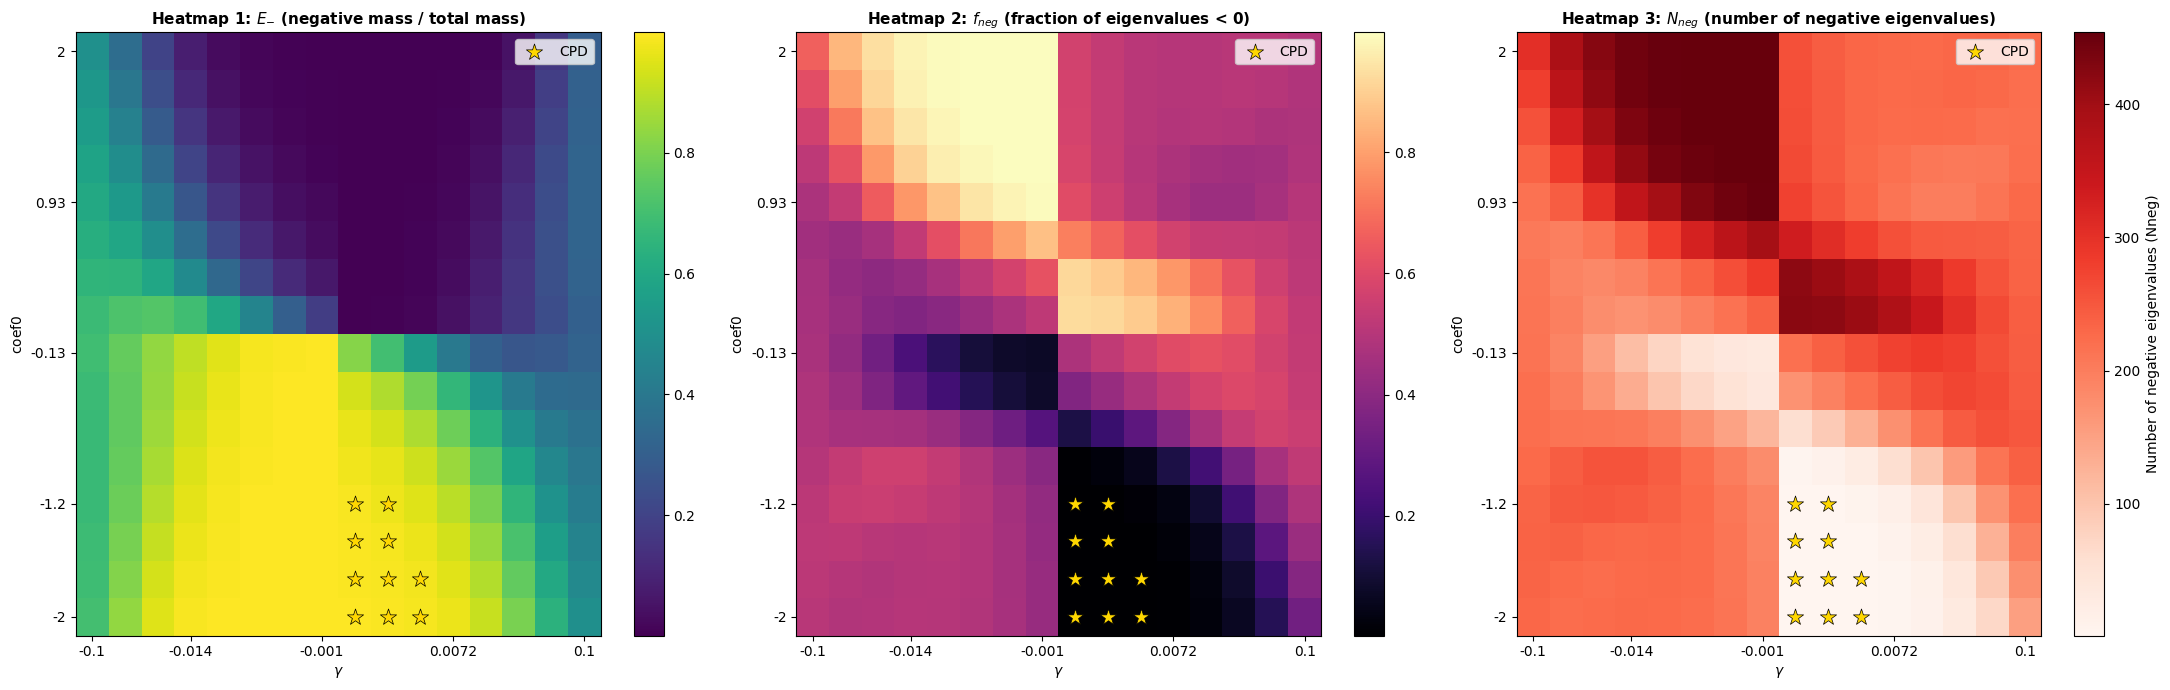

Heatmaps plotted


In [4]:
print("="*40)
print("Plotting heatmaps")
plot_heatmaps(gammas, coef0s, H1, H2, H3, H4)
print("Heatmaps plotted")
print("="*40)

Processing parameter combinations in parallel

Starting parallel processing


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2


Parallel processing completed

Creating delta F1 histograms


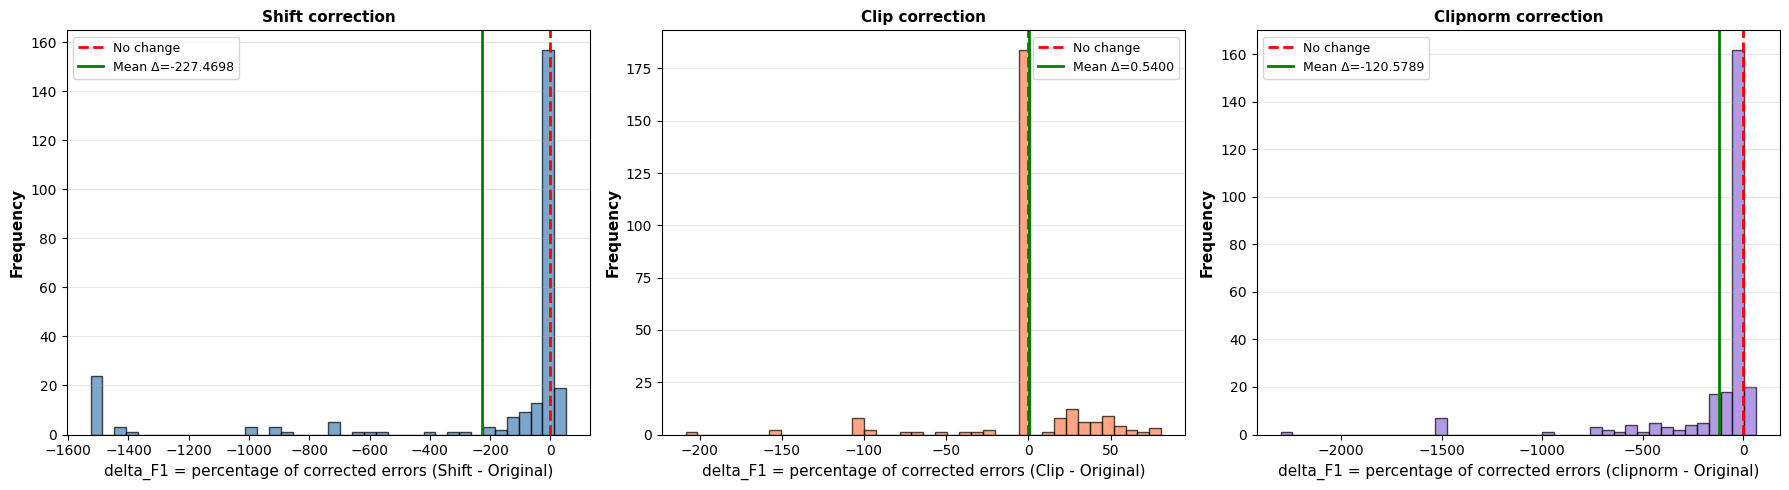


Delta F1 Statistics (Corrected - Original):
Positive values mean correction IMPROVED performance

Shift:
  Mean: -227.4698
  Std: 489.0412
  Min: -1525.8065
  Max: 52.3490
  Improved (Δ > 0): 29/256
  Degraded (Δ < 0): 93/256
  Unchanged (Δ ≈ 0): 134/256

Clip:
  Mean: 0.5400
  Std: 34.4326
  Min: -208.5714
  Max: 80.8333
  Improved (Δ > 0): 52/256
  Degraded (Δ < 0): 28/256
  Unchanged (Δ ≈ 0): 176/256

clipnorm:
  Mean: -120.5789
  Std: 317.1825
  Min: -2300.0000
  Max: 63.2759
  Improved (Δ > 0): 21/256
  Degraded (Δ < 0): 105/256
  Unchanged (Δ ≈ 0): 130/256


Best original (non-PSD) combination:
  gamma=0.001000, coef0=-2.000
  F1=0.9861, C=1000.0000

Parameter combinations with significant performance changes
(|ΔF1| > 0.03)

Shift Correction:
------------------------------------------------------------
  Found 122 significant combinations:

  1. gamma=0.100000, coef0=1.200
     ΔF1 = +52.3490 (✓ IMPROVED)
     F1: 0.9296 → 0.9664
     C:  0.1000 → 0.0215

  2. gamma=0.100000, co

In [ ]:
print("="*40)
print("Processing parameter combinations in parallel")
print("="*40)

# Create list of all parameter combinations
param_combinations = [(g, c) for g in gammas for c in coef0s]

print(f"\nStarting parallel processing")

# Parallel processing
results_list = Parallel(n_jobs=-1, verbose=10)(
    delayed(process_parameter_combination)(
        gamma, c, X_train_std, y_train, X_test_std, y_test, C_values
    )
    for gamma, c in param_combinations
)

print("\nParallel processing completed")

# Organize results
results = {
    'param_combinations': [],
    'original': {'f1': [], 'best_C': [], 'cv_f1': []},
    'shift': {'f1': [], 'best_C': [], 'cv_f1': []},
    'clip': {'f1': [], 'best_C': [], 'cv_f1': []},
    'clipnorm': {'f1': [], 'best_C': [], 'cv_f1': []}
}

# Populate results
for res in results_list:
    results['param_combinations'].append((res['gamma'], res['coef0']))
    for method in ['original', 'shift', 'clip', 'clipnorm']:
        results[method]['f1'].append(res[method]['f1'])
        results[method]['best_C'].append(res[method]['best_C'])
        results[method]['cv_f1'].append(res[method]['cv_f1'])

# Convert to numpy arrays
for key in ['original', 'shift', 'clip', 'clipnorm']:
    results[key]['f1'] = np.array(results[key]['f1'])
    results[key]['best_C'] = np.array(results[key]['best_C'])
    results[key]['cv_f1'] = np.array(results[key]['cv_f1'])

# F1 before/after
f1_orig      = results['original']['f1']
f1_shift     = results['shift']['f1']
f1_clip      = results['clip']['f1']
f1_clipnorm  = results['clipnorm']['f1']

# error rates = 1 - F1
err_orig     = 1.0 - f1_orig
err_shift    = 1.0 - f1_shift
err_clip     = 1.0 - f1_clip
err_clipnorm = 1.0 - f1_clipnorm

# relative error reduction (fraction of previous errors fixed)
impr_shift   = (err_orig - err_shift) / err_orig
impr_clip    = (err_orig - err_clip) / err_orig
impr_clipnorm = (err_orig - err_clipnorm) / err_orig

# Convert to percentage
impr_shift_pct    = 100 * impr_shift
impr_clip_pct     = 100 * impr_clip
impr_clipnorm_pct = 100 * impr_clipnorm


print("\n" + "="*40)
print("Creating delta F1 histograms")
print("="*40)

delta_f1_hist( impr_shift_pct, impr_clip_pct, impr_clipnorm_pct)

print("\nDelta F1 Statistics (Corrected - Original):")
print("Positive values mean correction IMPROVED performance\n")

for method, delta in [('Shift', impr_shift_pct), ('Clip', impr_clip_pct), ('clipnorm', impr_clipnorm_pct)]:
    print(f"{method}:")
    print(f"  Mean: {delta.mean():.4f}")
    print(f"  Std: {delta.std():.4f}")
    print(f"  Min: {delta.min():.4f}")
    print(f"  Max: {delta.max():.4f}")
    print(f"  Improved (Δ > 0): {np.sum(delta > 0)}/{len(delta)}")
    print(f"  Degraded (Δ < 0): {np.sum(delta < 0)}/{len(delta)}")
    print(f"  Unchanged (Δ ≈ 0): {np.sum(np.abs(delta) < 0.001)}/{len(delta)}")
    print()

# Find best overall combination
best_idx = np.argmax(results['original']['f1'])
print(f"\nBest original (non-PSD) combination:")
print(f"  gamma={results['param_combinations'][best_idx][0]:.6f}, "
      f"coef0={results['param_combinations'][best_idx][1]:.3f}")
print(f"  F1={results['original']['f1'][best_idx]:.4f}, "
      f"C={results['original']['best_C'][best_idx]:.4f}")

print("\n" + "="*60)
print("Parameter combinations with significant performance changes")
print("(|ΔF1| > 0.03)")
print("="*60)

threshold = 0.03

for method_name, delta in [('Shift', impr_shift_pct), ('Clip', impr_clip_pct), ('clipnorm', impr_clipnorm_pct)]:
    print(f"\n{method_name} Correction:")
    print("-" * 60)
    
    # Find indices where |delta| > threshold
    significant_idx = np.where(np.abs(delta) > threshold)[0]
    
    if len(significant_idx) == 0:
        print(f"  No combinations with |ΔF1| > {threshold}")
        continue
    
    print(f"  Found {len(significant_idx)} significant combinations:\n")
    
    # Sort by delta (most positive first = biggest improvement)
    sorted_idx = significant_idx[np.argsort(-delta[significant_idx])]
    
    for i, idx in enumerate(sorted_idx, 1):
        gamma_val = results['param_combinations'][idx][0]
        coef0_val = results['param_combinations'][idx][1]
        delta_val = delta[idx]
        f1_orig = results['original']['f1'][idx]
        f1_corr = results[method_name.lower()]['f1'][idx]
        C_orig = results['original']['best_C'][idx]
        C_corr = results[method_name.lower()]['best_C'][idx]
        
        # Determine if improvement or degradation
        status = "✓ IMPROVED" if delta_val > 0 else "✗ DEGRADED"
        
        print(f"  {i}. gamma={gamma_val:.6f}, coef0={coef0_val:.3f}")
        print(f"     ΔF1 = {delta_val:+.4f} ({status})")
        print(f"     F1: {f1_orig:.4f} → {f1_corr:.4f}")
        print(f"     C:  {C_orig:.4f} → {C_corr:.4f}")
        print()

print("\n" + "="*60)
print("Summary of significant changes")
print("="*60)

for method_name, delta in [('Shift', impr_shift_pct), ('Clip', impr_clip_pct), ('clipnorm', impr_clipnorm_pct)]:
    significant_improvements = np.sum(delta > threshold)
    significant_degradations = np.sum(delta < -threshold)
    
    print(f"\n{method_name}:")
    print(f"  Significant improvements (ΔF1 > +{threshold}): {significant_improvements}")
    print(f"  Significant degradations (ΔF1 < -{threshold}): {significant_degradations}")
    
    if significant_improvements > 0:
        best_improvement_idx = np.argmax(delta)
        print(f"  Best improvement: ΔF1 = {delta[best_improvement_idx]:+.4f} at "
              f"gamma={results['param_combinations'][best_improvement_idx][0]:.6f}, "
              f"coef0={results['param_combinations'][best_improvement_idx][1]:.3f}")
    
    if significant_degradations > 0:
        worst_degradation_idx = np.argmin(delta)
        print(f"  Worst degradation: ΔF1 = {delta[worst_degradation_idx]:+.4f} at "
              f"gamma={results['param_combinations'][worst_degradation_idx][0]:.6f}, "
              f"coef0={results['param_combinations'][worst_degradation_idx][1]:.3f}")


In [6]:
print("\n" + "="*60)
print("Parameter combinations where correction IMPROVED performance")
print("(ΔF1 > 0.03)")
print("="*60)

threshold = 0.03

for method_name, delta in [('Shift', impr_shift_pct), ('Clip', impr_clip_pct), ('clipnorm', impr_clipnorm_pct)]:
    print(f"\n{method_name} Correction:")
    print("-" * 60)
    
    # Find indices where delta > threshold (IMPROVEMENTS ONLY)
    improved_idx = np.where(delta > threshold)[0]
    
    if len(improved_idx) == 0:
        print(f"  No combinations with ΔF1 > {threshold}")
        continue
    
    print(f"  Found {len(improved_idx)} improved combinations:\n")
    
    # Sort by delta (biggest improvement first)
    sorted_idx = improved_idx[np.argsort(-delta[improved_idx])]
    
    for i, idx in enumerate(sorted_idx, 1):
        gamma_val = results['param_combinations'][idx][0]
        coef0_val = results['param_combinations'][idx][1]
        delta_val = delta[idx]
        f1_orig = results['original']['f1'][idx]
        f1_corr = results[method_name.lower()]['f1'][idx]
        C_orig = results['original']['best_C'][idx]
        C_corr = results[method_name.lower()]['best_C'][idx]
        
        print(f"  {i}. gamma={gamma_val:.6f}, coef0={coef0_val:.3f}")
        print(f"     ΔF1 = +{delta_val:.4f} (✓ IMPROVED)")
        print(f"     F1: {f1_orig:.4f} → {f1_corr:.4f}")
        print(f"     C:  {C_orig:.4f} → {C_corr:.4f}")
        print()

print("\n" + "="*60)
print("Summary of improvements")
print("="*60)

for method_name, delta in [('Shift', impr_shift_pct), ('Clip', impr_clip_pct), ('clipnorm', impr_clipnorm_pct)]:
    improved_count = np.sum(delta > threshold)
    total_improved = np.sum(delta > 0)
    
    print(f"\n{method_name}:")
    print(f"  Significant improvements (ΔF1 > {threshold}): {improved_count}/{len(delta)}")
    print(f"  Total improvements (ΔF1 > 0): {total_improved}/{len(delta)}")
    
    if improved_count > 0:
        best_improvement_idx = np.argmax(delta)
        print(f"  Best improvement: ΔF1 = +{delta[best_improvement_idx]:.4f} at "
              f"gamma={results['param_combinations'][best_improvement_idx][0]:.6f}, "
              f"coef0={results['param_combinations'][best_improvement_idx][1]:.3f}")
        print(f"  Mean improvement (of significant): {delta[delta > threshold].mean():.4f}")



Parameter combinations where correction IMPROVED performance
(ΔF1 > 0.03)

Shift Correction:
------------------------------------------------------------
  Found 29 improved combinations:

  1. gamma=0.100000, coef0=1.200
     ΔF1 = +52.3490 (✓ IMPROVED)
     F1: 0.9296 → 0.9664
     C:  0.1000 → 0.0215

  2. gamma=0.100000, coef0=0.667
     ΔF1 = +45.9562 (✓ IMPROVED)
     F1: 0.9371 → 0.9660
     C:  0.1000 → 0.1000

  3. gamma=0.007197, coef0=1.200
     ΔF1 = +44.7876 (✓ IMPROVED)
     F1: 0.9510 → 0.9730
     C:  10.0000 → 2.1544

  4. gamma=0.100000, coef0=0.933
     ΔF1 = +42.4324 (✓ IMPROVED)
     F1: 0.9296 → 0.9595
     C:  0.1000 → 0.1000

  5. gamma=0.013895, coef0=0.667
     ΔF1 = +40.4362 (✓ IMPROVED)
     F1: 0.9437 → 0.9664
     C:  2.1544 → 0.4642

  6. gamma=0.013895, coef0=2.000
     ΔF1 = +40.4362 (✓ IMPROVED)
     F1: 0.9437 → 0.9664
     C:  10.0000 → 2.1544

  7. gamma=0.026827, coef0=0.667
     ΔF1 = +40.4362 (✓ IMPROVED)
     F1: 0.9437 → 0.9664
     C:  0.4642


Analyzing kernel properties (negative eigenvalues and CPD)
Negative eigenvalues count - Min: 0.002197802197802198, Max: 0.9978021978021978, Mean: 0.50
Negative mass fraction - Min: 0.0001, Max: 0.9999, Mean: 0.5000
CPD kernels: 10 / 256

Creating analysis plots (★ = CPD, ● = Non-CPD)


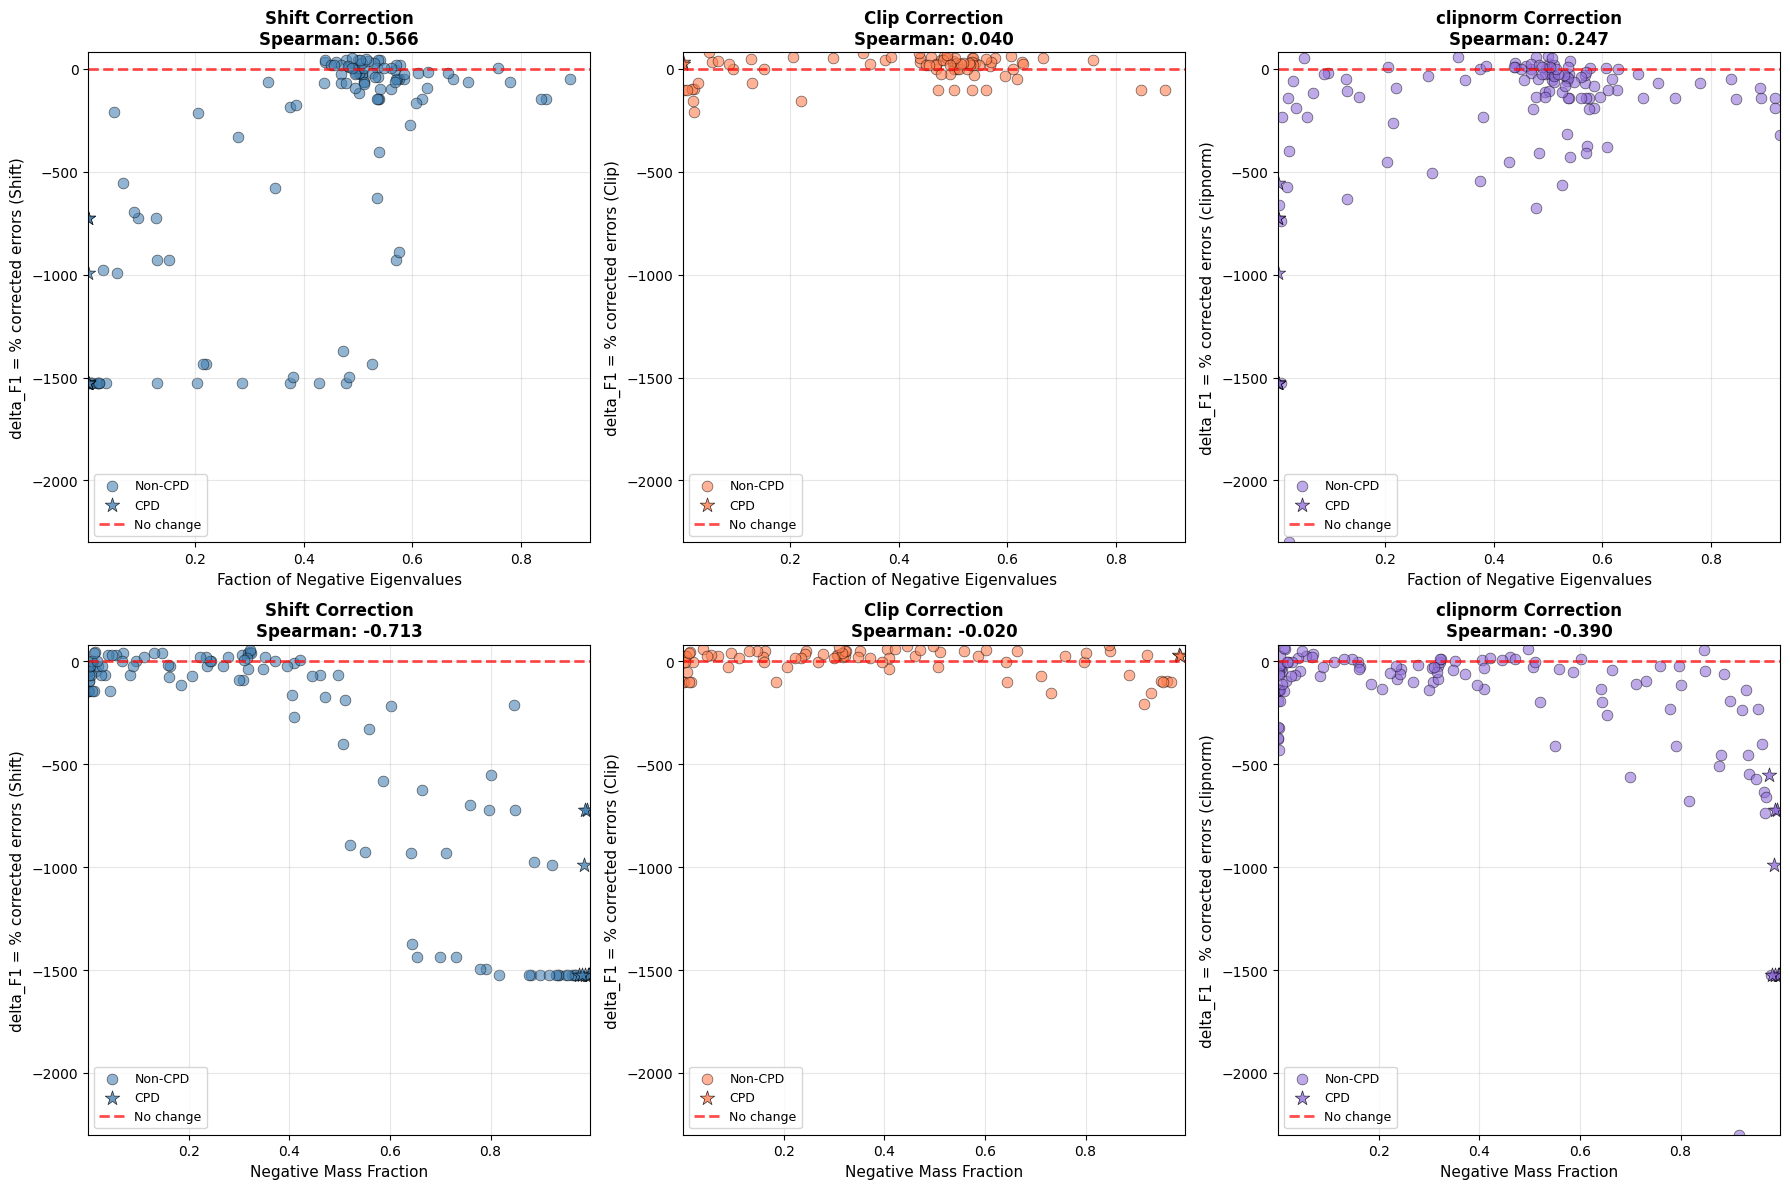

In [7]:
print("\n" + "="*60)
print("Analyzing kernel properties (negative eigenvalues and CPD)")
print("="*60)

frac_negative_eigenvalues = []
#n_negative_eigenvalues = []
negative_mass_fraction = []
is_cpd_arr = []

for gamma, c in results['param_combinations']:
    # Compute original kernel on full training set
    K_orig = sigmoid_kernel(X_train_std, X_train_std, gamma, c)
    
    # Compute eigenvalues
    eigenvals = np.linalg.eigvalsh(K_orig)
    
    # Count negative eigenvalues
    n_neg = np.sum(eigenvals < 0)
    n_tot = len(eigenvals)
    frac_negative_eigenvalues.append(n_neg/n_tot)
    
    # Calculate negative mass fraction
    neg_eigenvals = eigenvals[eigenvals < 0]
    if len(neg_eigenvals) > 0:
        neg_mass = np.abs(neg_eigenvals).sum()
        total_mass = np.abs(eigenvals).sum()
        neg_frac = neg_mass / total_mass if total_mass > 0 else 0
    else:
        neg_frac = 0
    negative_mass_fraction.append(neg_frac)
    
    # Check CPD status
    is_cpd_arr.append(is_cpd(K_orig))

# Convert to numpy arrays
frac_negative_eigenvalues = np.array(frac_negative_eigenvalues)
negative_mass_fraction = np.array(negative_mass_fraction)
is_cpd_arr = np.array(is_cpd_arr)

print(f"Negative eigenvalues count - Min: {frac_negative_eigenvalues.min()}, "
      f"Max: {frac_negative_eigenvalues.max()}, Mean: {frac_negative_eigenvalues.mean():.2f}")
print(f"Negative mass fraction - Min: {negative_mass_fraction.min():.4f}, "
      f"Max: {negative_mass_fraction.max():.4f}, Mean: {negative_mass_fraction.mean():.4f}")
print(f"CPD kernels: {np.sum(is_cpd_arr)} / {len(is_cpd_arr)}")

# Prepare methods for plotting
methods = [('Shift', impr_shift_pct, 'steelblue'),
            ('Clip', impr_clip_pct, 'coral'),
            ('clipnorm', impr_clipnorm_pct, 'mediumpurple')]

print("\n" + "="*60)
print("Creating analysis plots (★ = CPD, ● = Non-CPD)")
print("="*60)

correction_plots_eig(methods, frac_negative_eigenvalues, negative_mass_fraction, is_cpd_arr)


Creating scatter plots: ΔF1 vs Kernel Properties (★ = CPD, ● = Non-CPD)


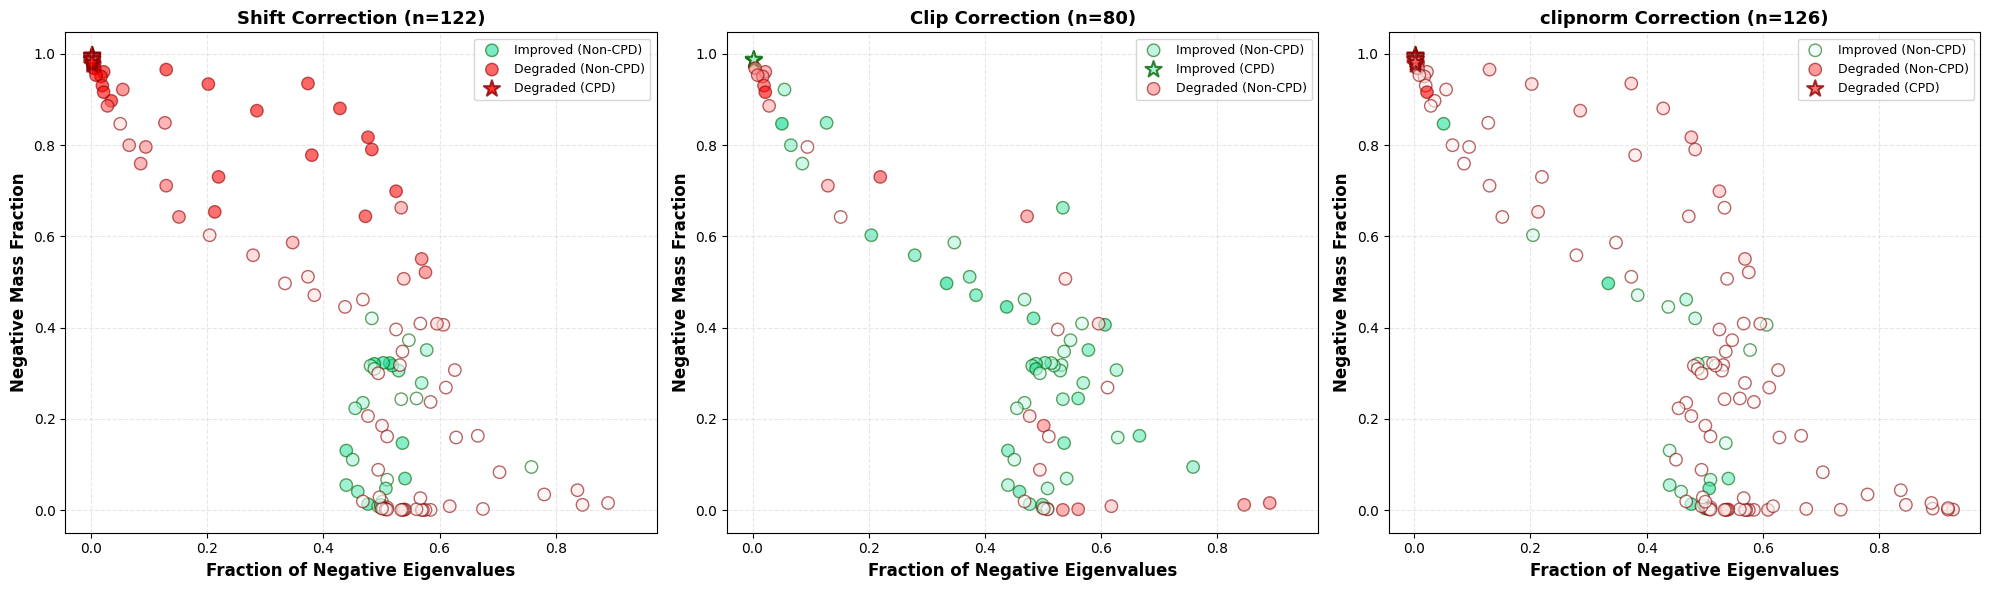

In [8]:
print("\n" + "="*60)
print("Creating scatter plots: ΔF1 vs Kernel Properties (★ = CPD, ● = Non-CPD)")
print("="*60)

correction_plots_imp(methods, frac_negative_eigenvalues, negative_mass_fraction, is_cpd_arr)


Plot: gamma vs coef0 with |ΔF1| (★ = CPD, ● = Non-CPD)


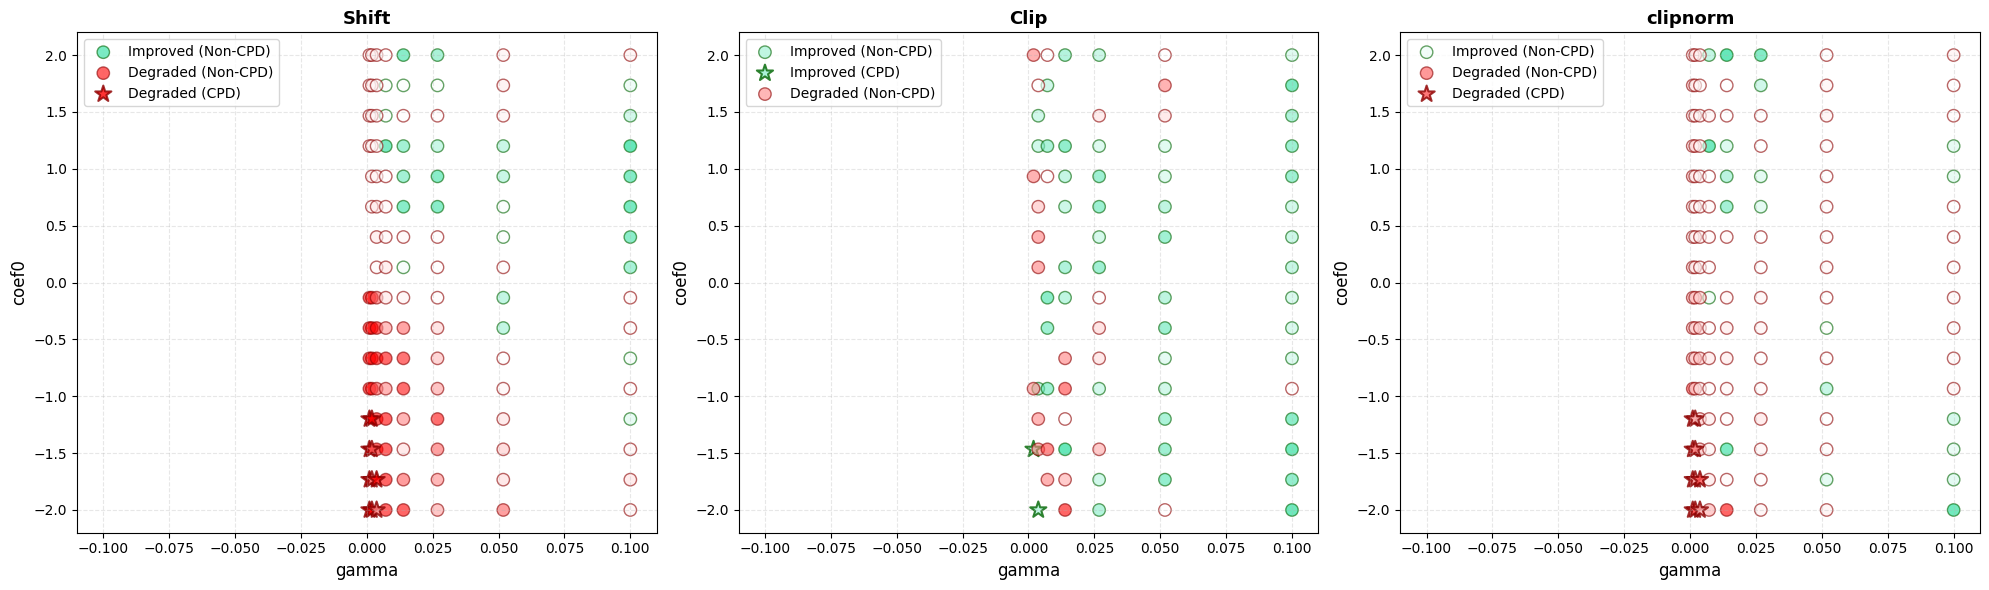


Plot: Baseline F1 (original) vs ΔF1 (3 variants) (★ = CPD, ● = Non-CPD)


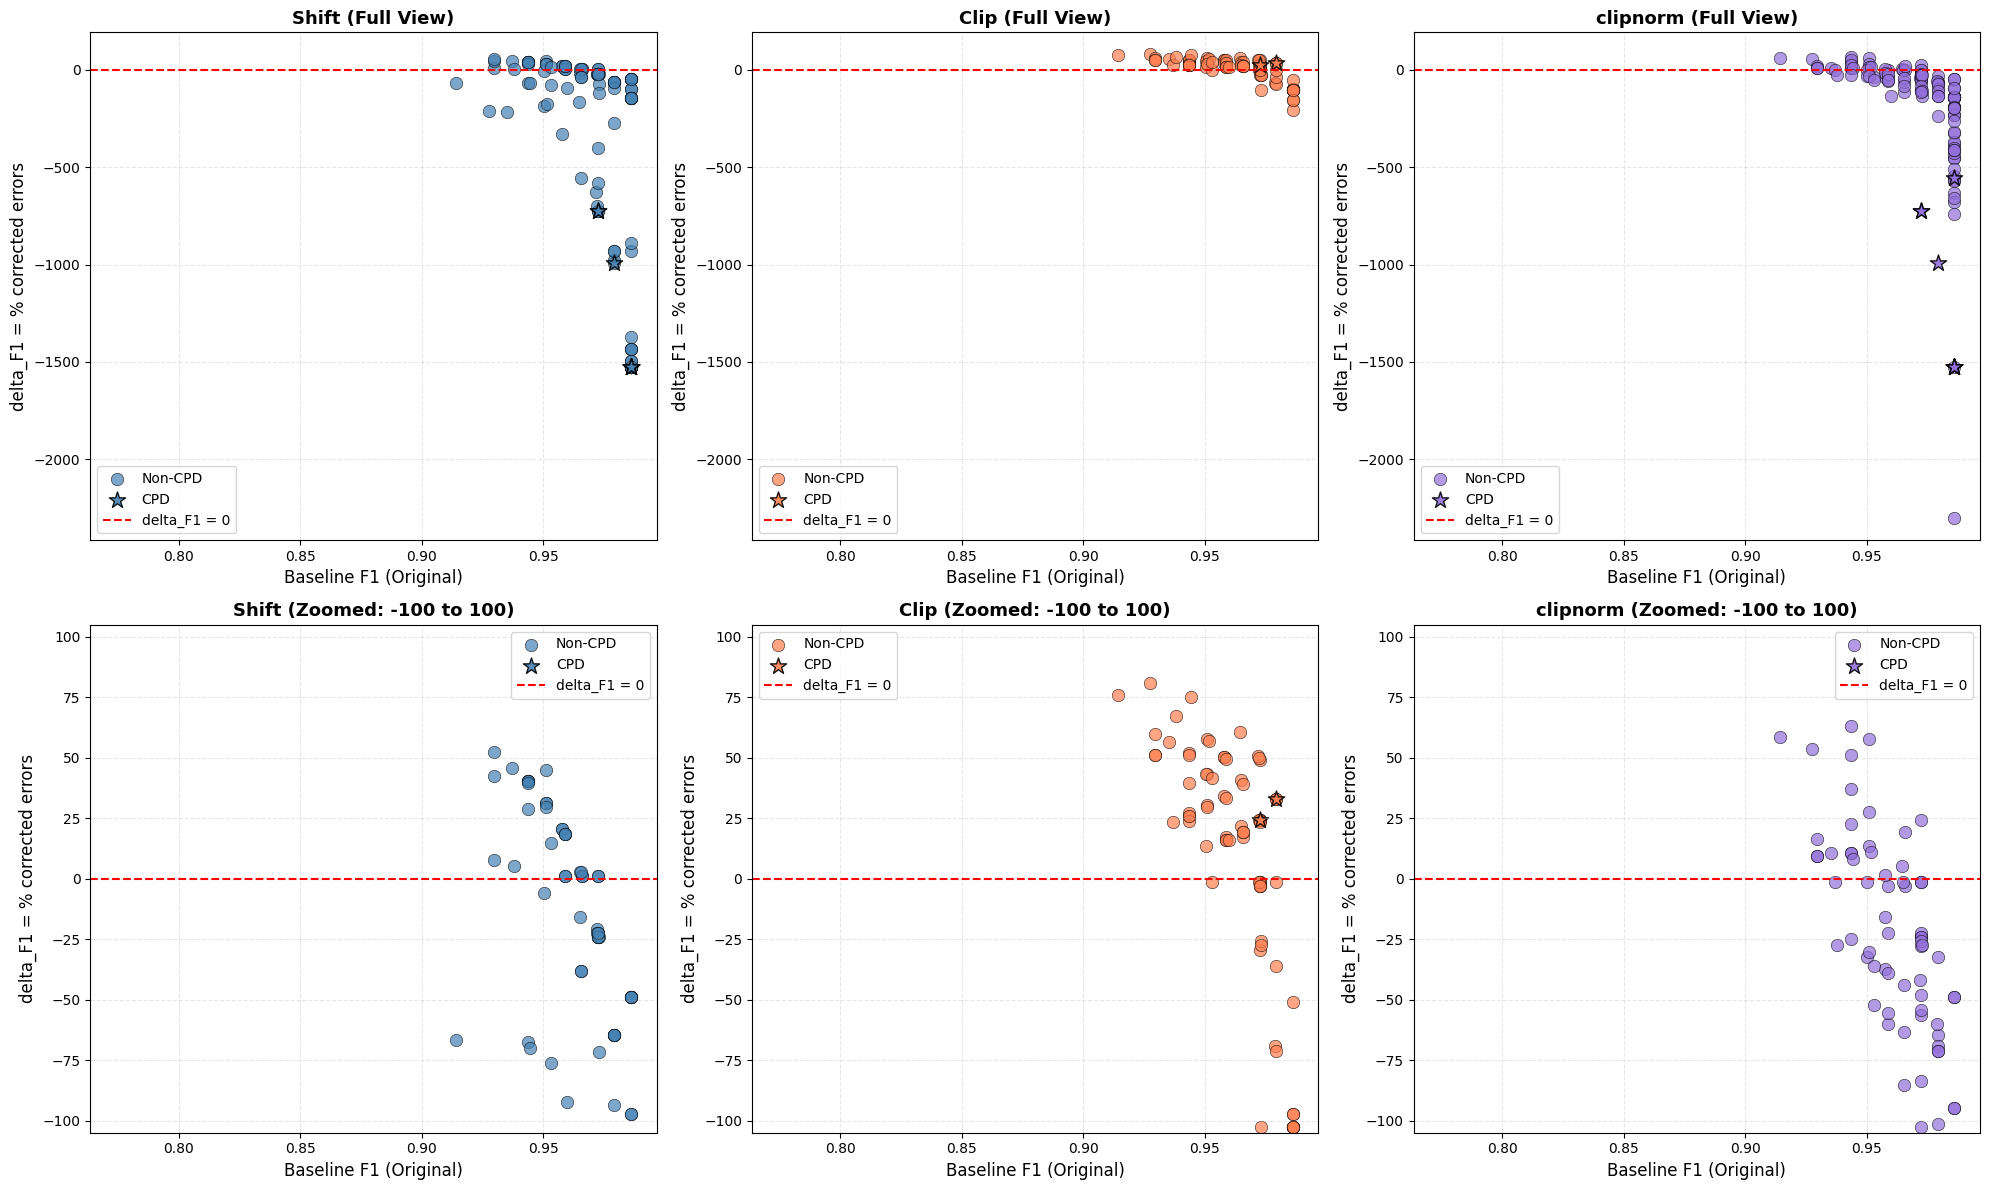

In [9]:
print("\n" + "="*60)
print("Plot: gamma vs coef0 with |ΔF1| (★ = CPD, ● = Non-CPD)")
print("="*60)

correction_plots_coefs(results, methods, is_cpd_arr)

print("\n" + "="*60)
print("Plot: Baseline F1 (original) vs ΔF1 (3 variants) (★ = CPD, ● = Non-CPD)")
print("="*60)

correction_plots_baseline(results, impr_shift_pct, impr_clip_pct, impr_clipnorm_pct, is_cpd_arr)

## Sigmoid Kernel with Normalized Dot Product

In [10]:
print("="*80)
print("EXPERIMENT 2: Sigmoid Kernel with Normalized Dot Product")
print("K(x, y) = tanh(gamma * cos_sim(x, y) + coef0)")
print("where cos_sim(x, y) = <x, y> / (||x|| * ||y||)")
print("="*80)

EXPERIMENT 2: Sigmoid Kernel with Normalized Dot Product
K(x, y) = tanh(gamma * cos_sim(x, y) + coef0)
where cos_sim(x, y) = <x, y> / (||x|| * ||y||)


In [11]:
print("="*40)
print("Scanning parameter grid (Normalized Kernel)")
print("="*40)

# For normalized kernel, the dot product is in [-1, 1], so we use different gamma range
gammas1 = np.logspace(-.5, .5, 8)
gammas2 = -np.logspace(-.5, .5, 8)
gammas_norm = sorted(np.concatenate((gammas2, gammas1)))
coef0s_norm = np.linspace(-2, 2, 16)

# Scan parameter grid
H1_norm, H2_norm, H3_norm, H4_norm = scan_param_grid_normalized(X_train_std, gammas_norm, coef0s_norm, tol=1e-10)
print(f"CPD kernels found: {np.sum(H4_norm)} / {H4_norm.size}")
print("Parameter grid scanned")
print("="*40)

Scanning parameter grid (Normalized Kernel)
CPD kernels found: 12 / 256
Parameter grid scanned


Plotting heatmaps (Normalized Kernel)


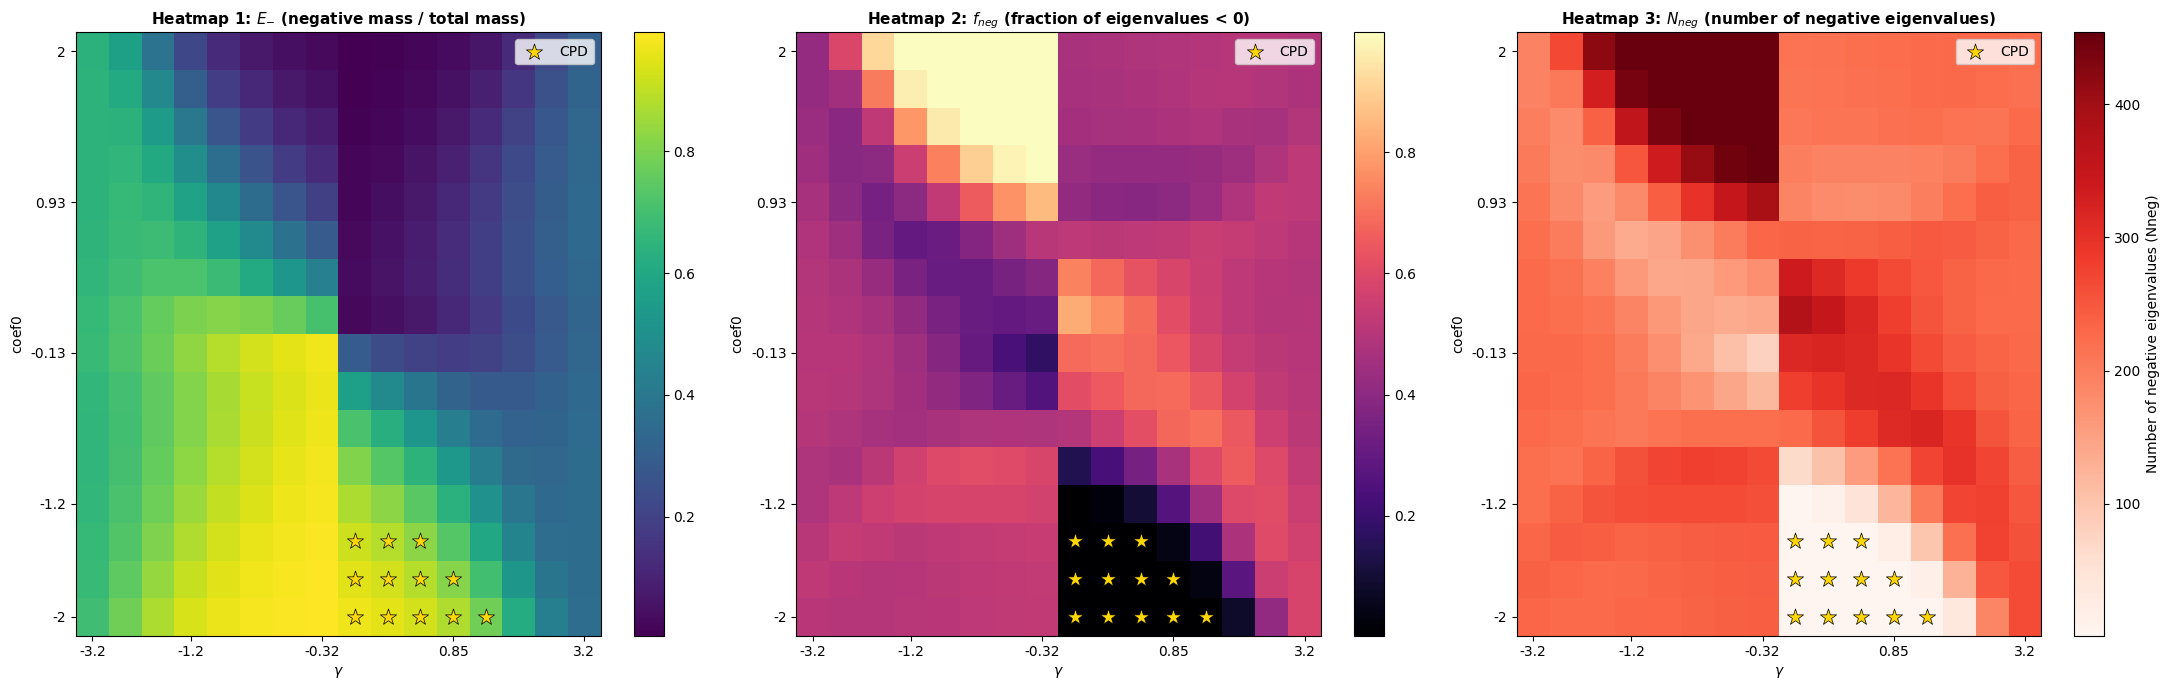

Heatmaps plotted


In [12]:
print("="*40)
print("Plotting heatmaps (Normalized Kernel)")
print("="*40)
plot_heatmaps(gammas_norm, coef0s_norm, H1_norm, H2_norm, H3_norm, H4_norm)
print("Heatmaps plotted")
print("="*40)

Processing parameter combinations in parallel (Normalized Kernel)

Starting parallel processing


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3


Parallel processing completed

Creating delta F1 histograms (Normalized Kernel)


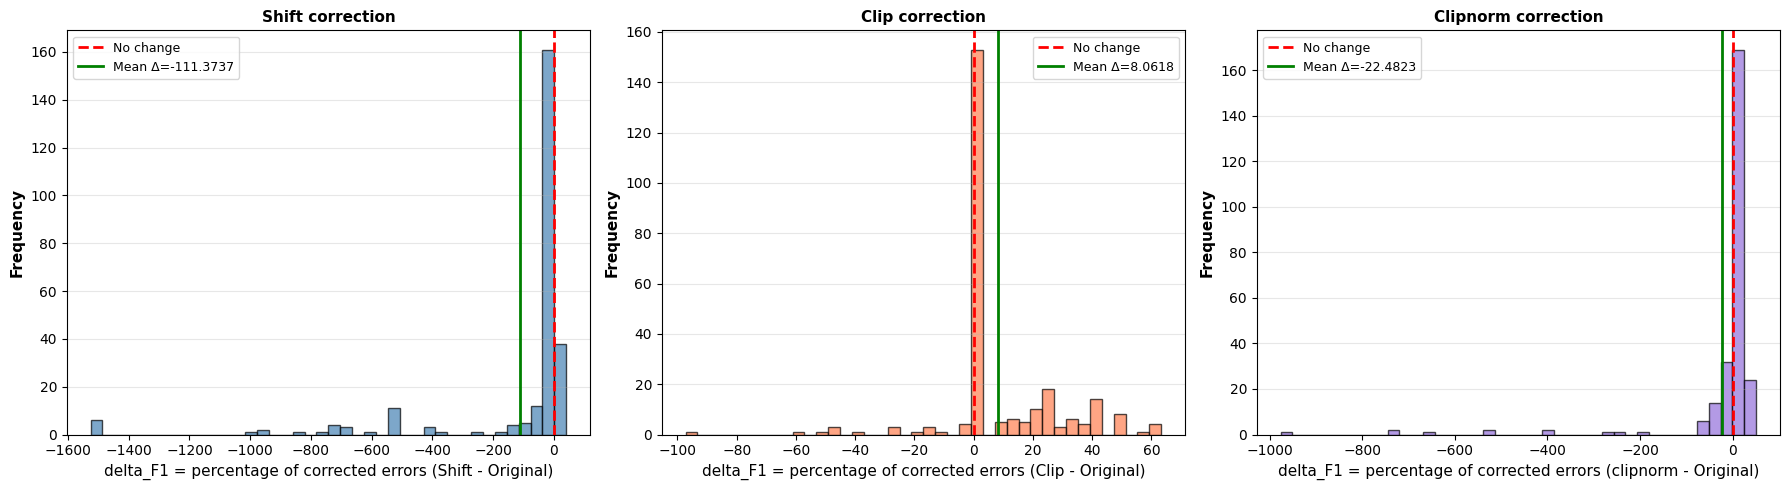


Delta F1 Statistics (Corrected - Original) - Normalized Kernel:
Positive values mean correction IMPROVED performance

Shift:
  Mean: -111.3737
  Std: 299.3092
  Min: -1525.8065
  Max: 40.8392
  Improved (Δ > 0): 38/256
  Degraded (Δ < 0): 73/256
  Unchanged (Δ ≈ 0): 145/256

Clip:
  Mean: 8.0618
  Std: 20.4414
  Min: -97.2603
  Max: 63.2867
  Improved (Δ > 0): 89/256
  Degraded (Δ < 0): 19/256
  Unchanged (Δ ≈ 0): 148/256

clipnorm:
  Mean: -22.4823
  Std: 116.3281
  Min: -976.3441
  Max: 50.6944
  Improved (Δ > 0): 49/256
  Degraded (Δ < 0): 63/256
  Unchanged (Δ ≈ 0): 144/256


Best original (non-PSD) combination (Normalized Kernel):
  gamma=0.316228, coef0=-1.200
  F1=0.9861, C=2.1544


In [13]:
print("="*40)
print("Processing parameter combinations in parallel (Normalized Kernel)")
print("="*40)

# Create list of all parameter combinations for normalized kernel
param_combinations_norm = [(g, c) for g in gammas_norm for c in coef0s_norm]

print(f"\nStarting parallel processing")

# Parallel processing
results_list_norm = Parallel(n_jobs=-1, verbose=10)(
    delayed(process_parameter_combination_normalized)(
        gamma, c, X_train_std, y_train, X_test_std, y_test, C_values
    )
    for gamma, c in param_combinations_norm
)

print("\nParallel processing completed")

# Organize results
results_norm = {
    'param_combinations': [],
    'original': {'f1': [], 'best_C': [], 'cv_f1': []},
    'shift': {'f1': [], 'best_C': [], 'cv_f1': []},
    'clip': {'f1': [], 'best_C': [], 'cv_f1': []},
    'clipnorm': {'f1': [], 'best_C': [], 'cv_f1': []}
}

# Populate results
for res in results_list_norm:
    results_norm['param_combinations'].append((res['gamma'], res['coef0']))
    for method in ['original', 'shift', 'clip', 'clipnorm']:
        results_norm[method]['f1'].append(res[method]['f1'])
        results_norm[method]['best_C'].append(res[method]['best_C'])
        results_norm[method]['cv_f1'].append(res[method]['cv_f1'])

# Convert to numpy arrays
for key in ['original', 'shift', 'clip', 'clipnorm']:
    results_norm[key]['f1'] = np.array(results_norm[key]['f1'])
    results_norm[key]['best_C'] = np.array(results_norm[key]['best_C'])
    results_norm[key]['cv_f1'] = np.array(results_norm[key]['cv_f1'])

# F1 before/after
f1_orig_norm      = results_norm['original']['f1']
f1_shift_norm     = results_norm['shift']['f1']
f1_clip_norm      = results_norm['clip']['f1']
f1_clipnorm_norm  = results_norm['clipnorm']['f1']

# error rates = 1 - F1
err_orig_norm     = 1.0 - f1_orig_norm
err_shift_norm    = 1.0 - f1_shift_norm
err_clip_norm     = 1.0 - f1_clip_norm
err_clipnorm_norm = 1.0 - f1_clipnorm_norm

# relative error reduction (fraction of previous errors fixed)
impr_shift_norm   = (err_orig_norm - err_shift_norm) / err_orig_norm
impr_clip_norm    = (err_orig_norm - err_clip_norm) / err_orig_norm
impr_clipnorm_norm = (err_orig_norm - err_clipnorm_norm) / err_orig_norm

# Convert to percentage
impr_shift_pct_norm    = 100 * impr_shift_norm
impr_clip_pct_norm     = 100 * impr_clip_norm
impr_clipnorm_norm_pct = 100 * impr_clipnorm_norm

print("\n" + "="*40)
print("Creating delta F1 histograms (Normalized Kernel)")
print("="*40)

delta_f1_hist(impr_shift_pct_norm, impr_clip_pct_norm, impr_clipnorm_norm_pct, suffix='_norm')

print("\nDelta F1 Statistics (Corrected - Original) - Normalized Kernel:")
print("Positive values mean correction IMPROVED performance\n")

for method, delta in [('Shift', impr_shift_pct_norm), ('Clip', impr_clip_pct_norm), ('clipnorm', impr_clipnorm_norm_pct)]:
    print(f"{method}:")
    print(f"  Mean: {delta.mean():.4f}")
    print(f"  Std: {delta.std():.4f}")
    print(f"  Min: {delta.min():.4f}")
    print(f"  Max: {delta.max():.4f}")
    print(f"  Improved (Δ > 0): {np.sum(delta > 0)}/{len(delta)}")
    print(f"  Degraded (Δ < 0): {np.sum(delta < 0)}/{len(delta)}")
    print(f"  Unchanged (Δ ≈ 0): {np.sum(np.abs(delta) < 0.001)}/{len(delta)}")
    print()

# Find best overall combination
best_idx_norm = np.argmax(results_norm['original']['f1'])
print(f"\nBest original (non-PSD) combination (Normalized Kernel):")
print(f"  gamma={results_norm['param_combinations'][best_idx_norm][0]:.6f}, "
      f"coef0={results_norm['param_combinations'][best_idx_norm][1]:.3f}")
print(f"  F1={results_norm['original']['f1'][best_idx_norm]:.4f}, "
      f"C={results_norm['original']['best_C'][best_idx_norm]:.4f}")


Analyzing kernel properties (Normalized Kernel)
Negative eigenvalues fraction - Min: 0.0022, Max: 0.9978, Mean: 0.5000
Negative mass fraction - Min: 0.0043, Max: 0.9957, Mean: 0.5000
CPD kernels: 12 / 256

Creating analysis plots (★ = CPD, ● = Non-CPD) - Normalized Kernel


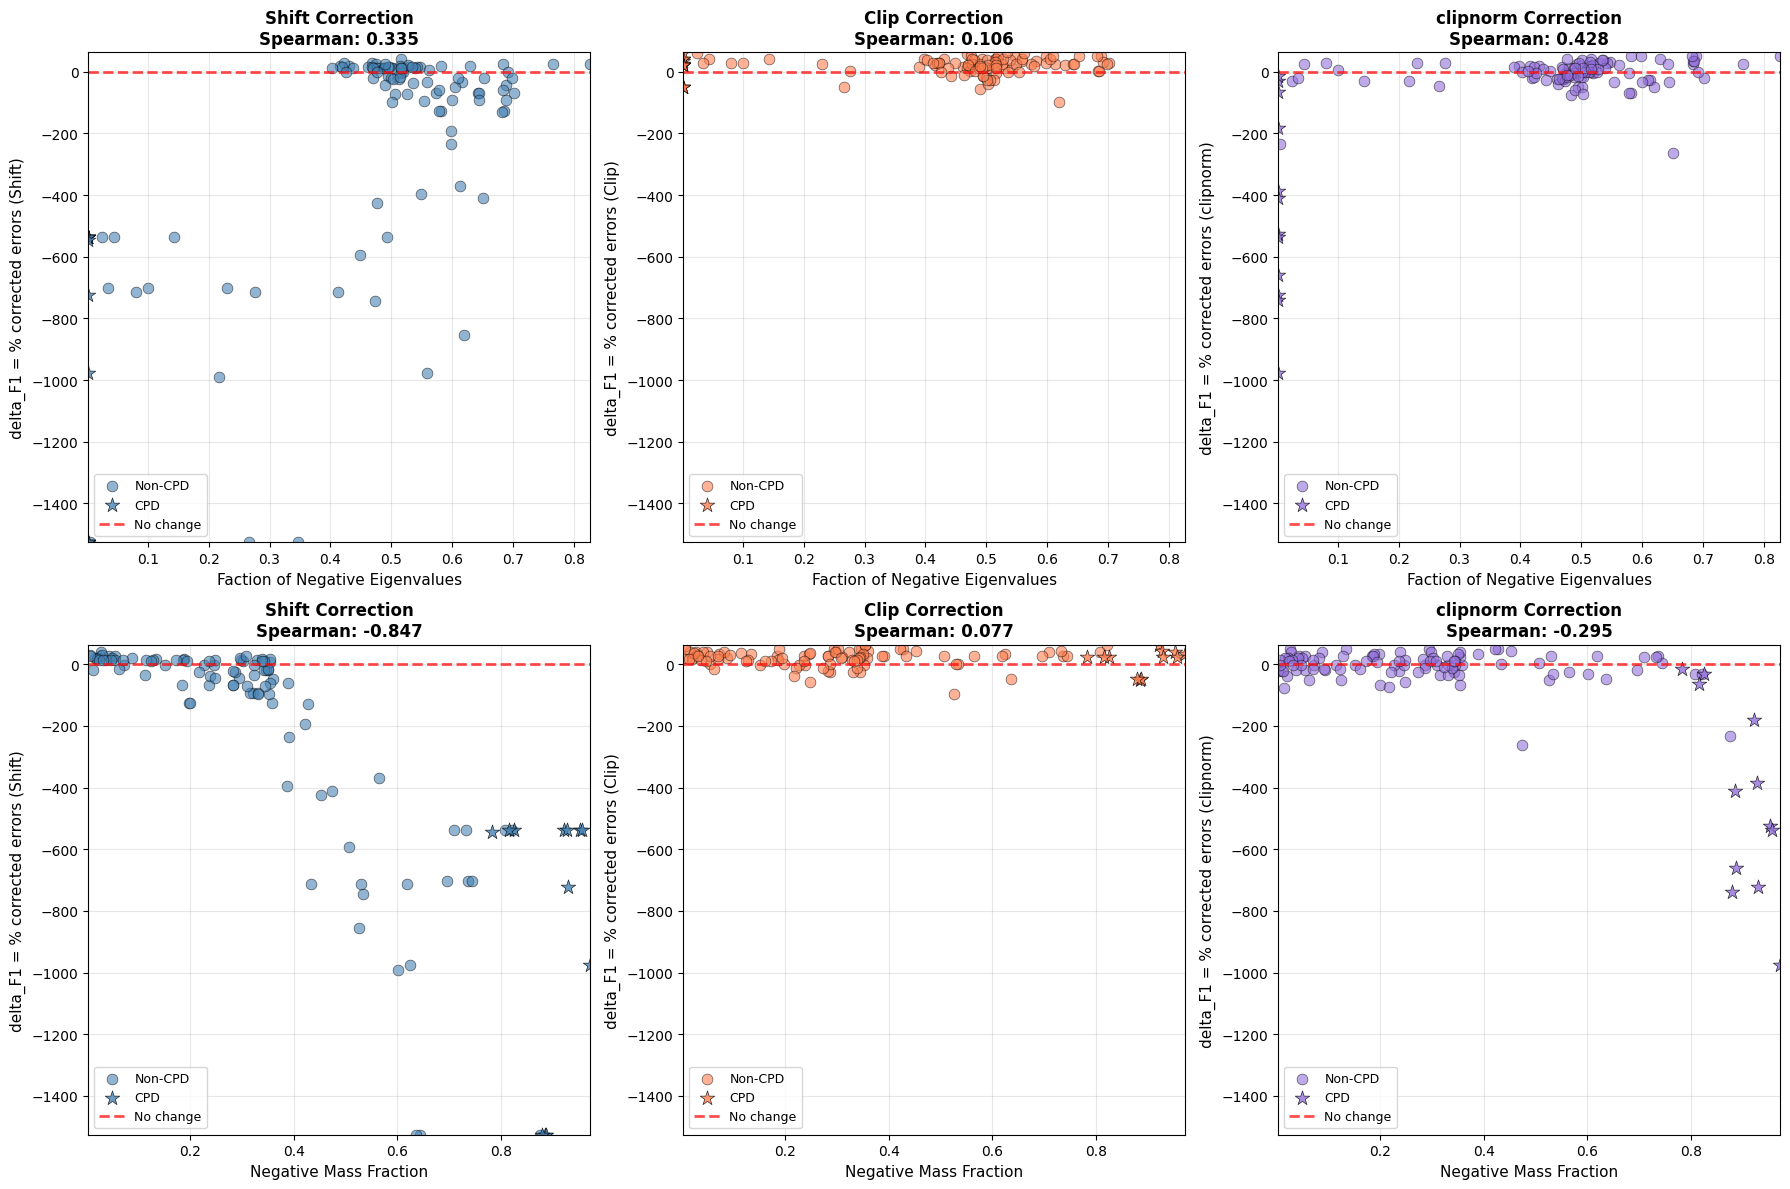

In [14]:
print("\n" + "="*60)
print("Analyzing kernel properties (Normalized Kernel)")
print("="*60)

frac_negative_eigenvalues_norm = []
negative_mass_fraction_norm = []
is_cpd_arr_norm = []

for gamma, c in results_norm['param_combinations']:
    # Compute original kernel on full training set
    K_orig = sigmoid_kernel_normalized(X_train_std, X_train_std, gamma, c)
    
    # Compute eigenvalues
    eigenvals = np.linalg.eigvalsh(K_orig)
    
    # Count negative eigenvalues and compute fraction
    n_neg = np.sum(eigenvals < 0)
    n_tot = len(eigenvals)
    frac_negative_eigenvalues_norm.append(n_neg/n_tot)
    
    # Calculate negative mass fraction
    neg_eigenvals = eigenvals[eigenvals < 0]
    if len(neg_eigenvals) > 0:
        neg_mass = np.abs(neg_eigenvals).sum()
        total_mass = np.abs(eigenvals).sum()
        neg_frac = neg_mass / total_mass if total_mass > 0 else 0
    else:
        neg_frac = 0
    negative_mass_fraction_norm.append(neg_frac)
    
    # Check CPD status
    is_cpd_arr_norm.append(is_cpd(K_orig))

# Convert to numpy arrays
frac_negative_eigenvalues_norm = np.array(frac_negative_eigenvalues_norm)
negative_mass_fraction_norm = np.array(negative_mass_fraction_norm)
is_cpd_arr_norm = np.array(is_cpd_arr_norm)

print(f"Negative eigenvalues fraction - Min: {frac_negative_eigenvalues_norm.min():.4f}, "
      f"Max: {frac_negative_eigenvalues_norm.max():.4f}, Mean: {frac_negative_eigenvalues_norm.mean():.4f}")
print(f"Negative mass fraction - Min: {negative_mass_fraction_norm.min():.4f}, "
      f"Max: {negative_mass_fraction_norm.max():.4f}, Mean: {negative_mass_fraction_norm.mean():.4f}")
print(f"CPD kernels: {np.sum(is_cpd_arr_norm)} / {len(is_cpd_arr_norm)}")

methods_norm = [('Shift', impr_shift_pct_norm, 'steelblue'),
                ('Clip', impr_clip_pct_norm, 'coral'),
                ('clipnorm', impr_clipnorm_norm_pct, 'mediumpurple')]

print("\n" + "="*60)
print("Creating analysis plots (★ = CPD, ● = Non-CPD) - Normalized Kernel")
print("="*60)

correction_plots_eig(methods_norm, frac_negative_eigenvalues_norm, negative_mass_fraction_norm, is_cpd_arr_norm, suffix='_norm')


Creating scatter plots (★ = CPD, ● = Non-CPD) - Normalized Kernel


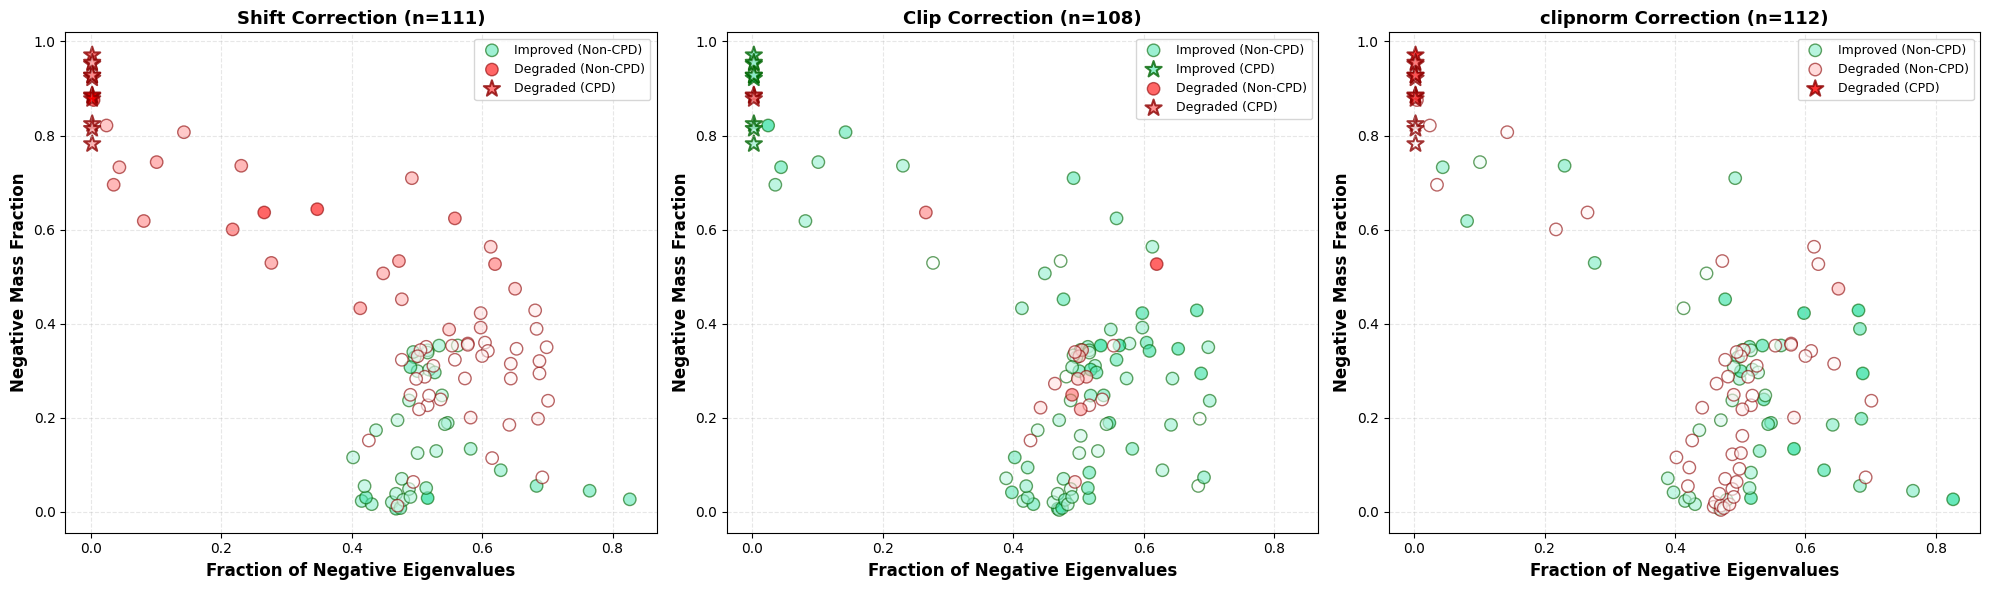

In [15]:
print("\n" + "="*60)
print("Creating scatter plots (★ = CPD, ● = Non-CPD) - Normalized Kernel")
print("="*60)

correction_plots_imp(methods_norm, frac_negative_eigenvalues_norm, negative_mass_fraction_norm, is_cpd_arr_norm, suffix='_norm')


Plot: gamma vs coef0 (★ = CPD, ● = Non-CPD) - Normalized Kernel


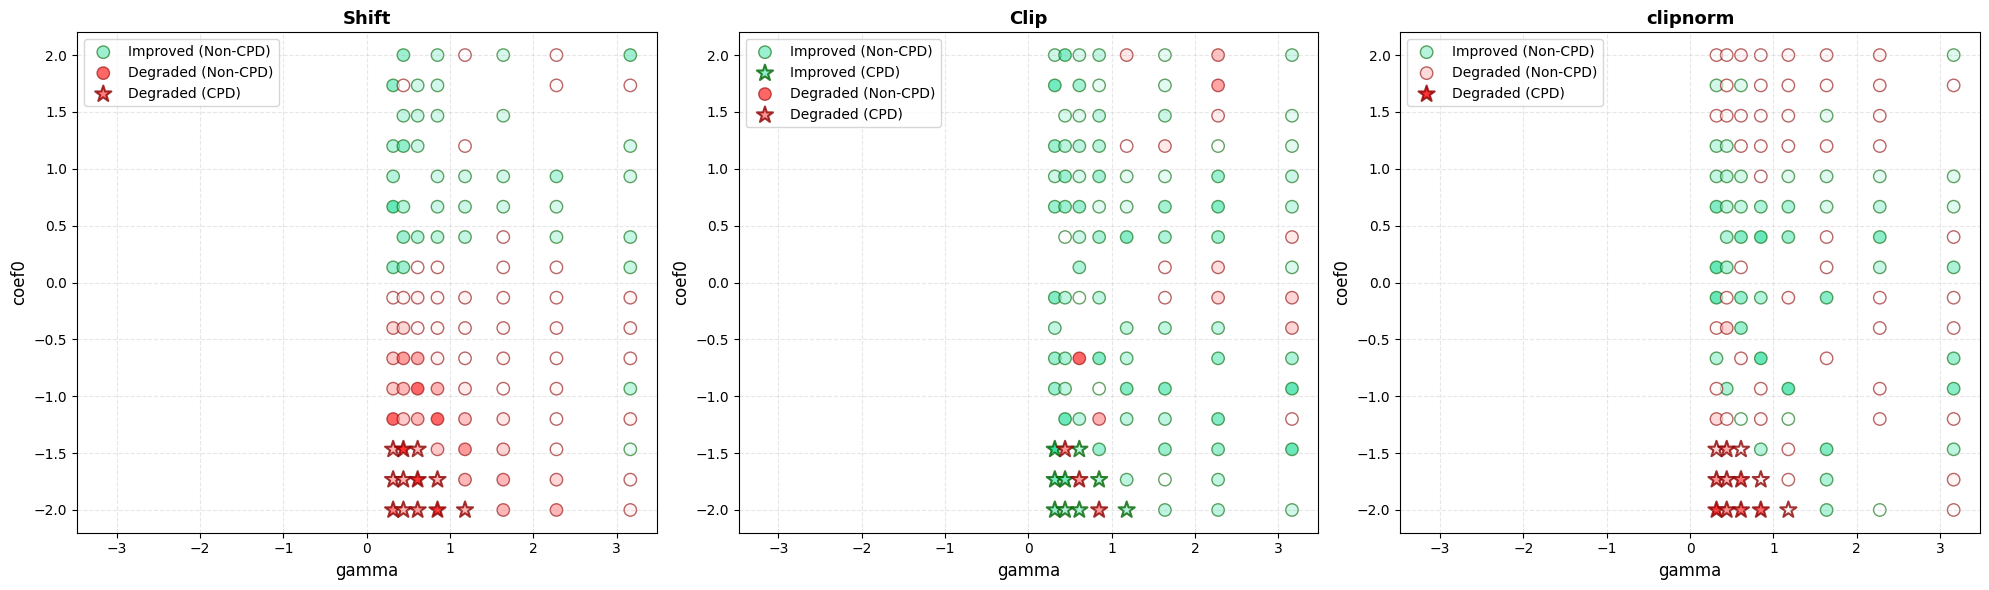


Plot: Baseline F1 vs ΔF1 (★ = CPD, ● = Non-CPD) - Normalized Kernel


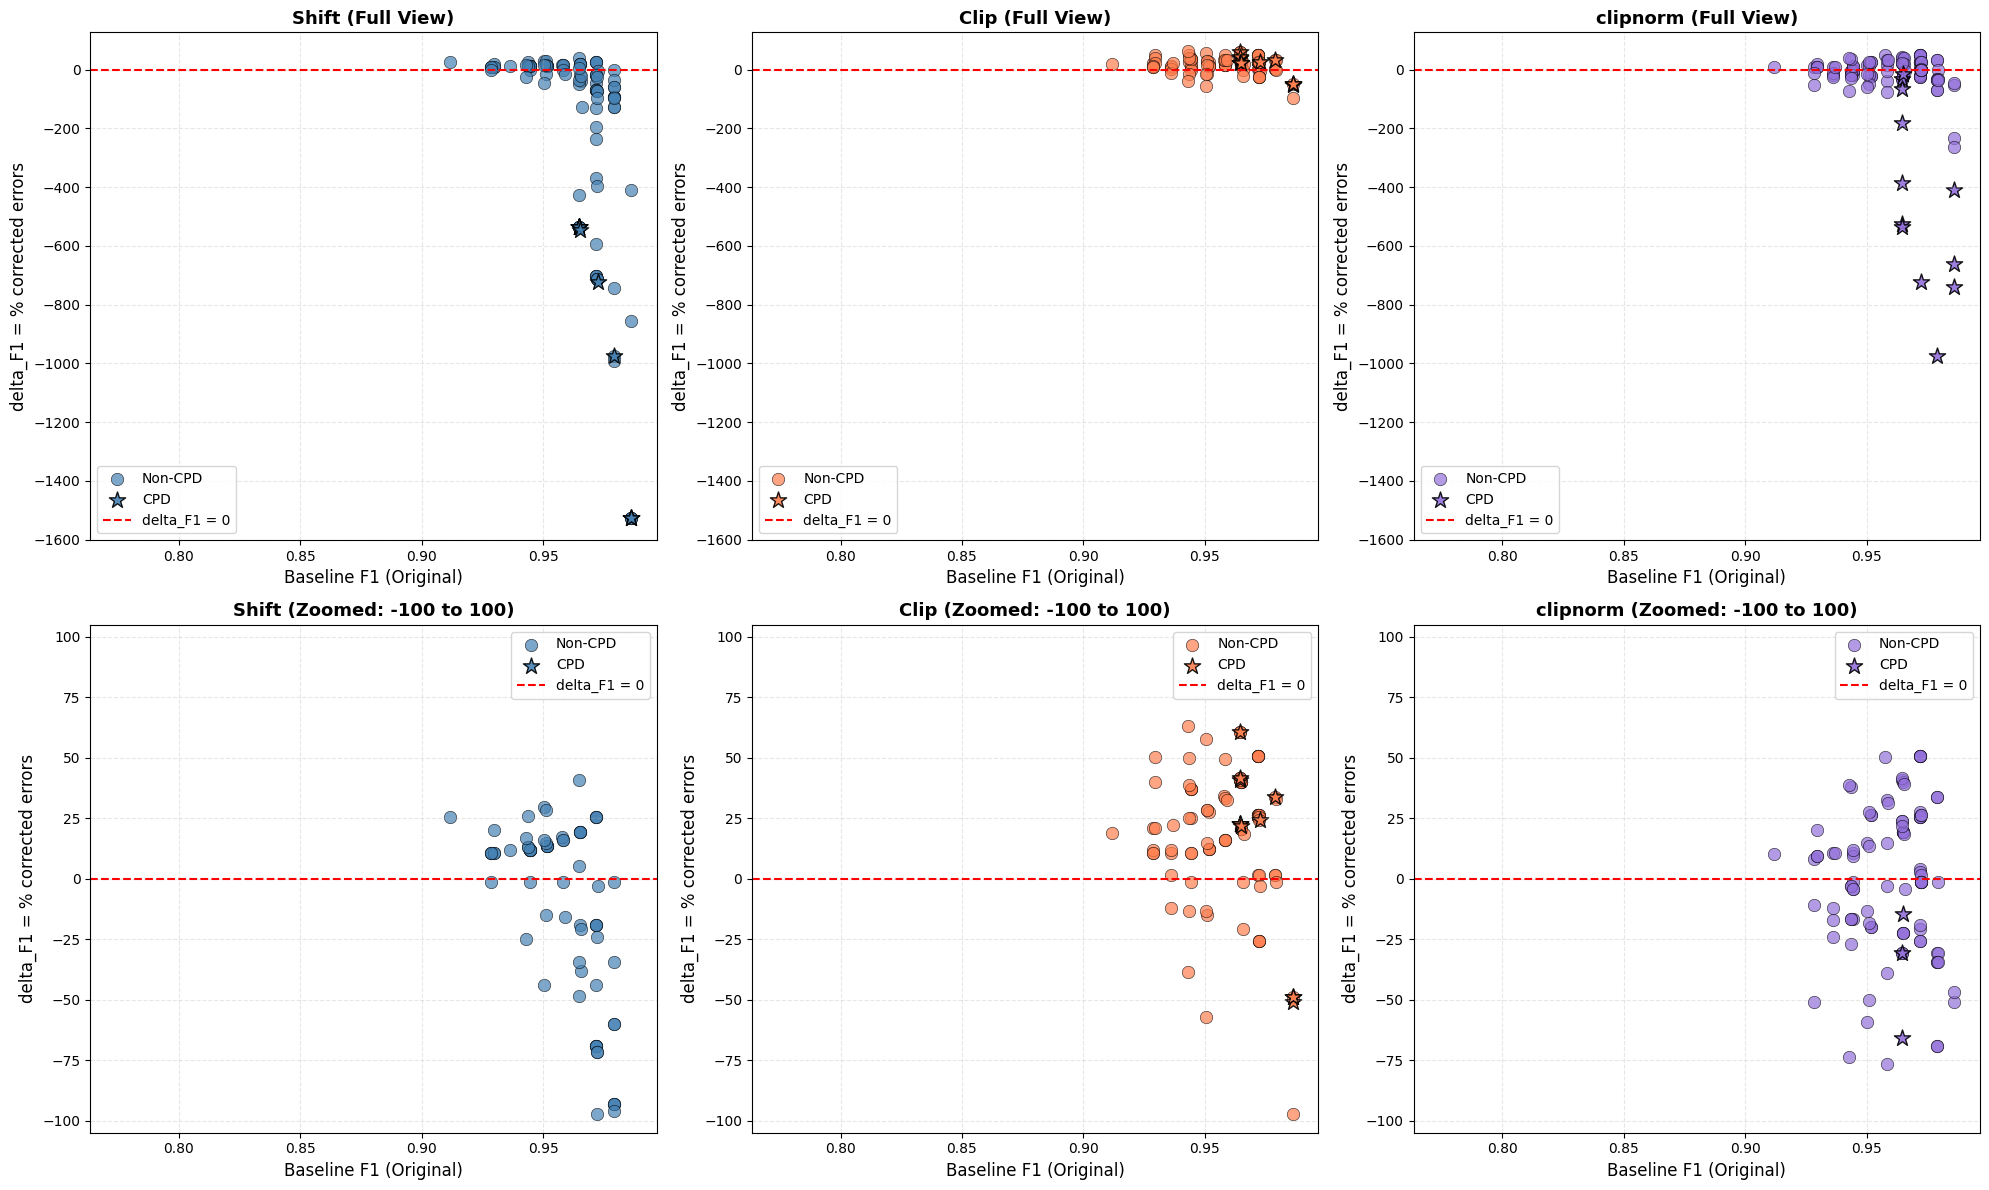

In [16]:
print("\n" + "="*60)
print("Plot: gamma vs coef0 (★ = CPD, ● = Non-CPD) - Normalized Kernel")
print("="*60)

correction_plots_coefs(results_norm, methods_norm, is_cpd_arr_norm, suffix='_norm')

print("\n" + "="*60)
print("Plot: Baseline F1 vs ΔF1 (★ = CPD, ● = Non-CPD) - Normalized Kernel")
print("="*60)

correction_plots_baseline(results_norm, impr_shift_pct_norm, impr_clip_pct_norm, impr_clipnorm_norm_pct, is_cpd_arr_norm, suffix='_norm')

In [17]:
print("="*80)
print("COMPARISON: Standard vs Normalized Sigmoid Kernel")
print("="*80)

# Check if both experiments have been run
exp1_available = 'results' in dir() and 'is_cpd_arr' in dir()
exp2_available = 'results_norm' in dir() and 'is_cpd_arr_norm' in dir()

if not exp1_available:
    print("\n⚠ WARNING: Experiment 1 (Standard Kernel) results not found.")
    print("  Please run cells 3-9 first to generate standard kernel results.")

if not exp2_available:
    print("\n⚠ WARNING: Experiment 2 (Normalized Kernel) results not found.")
    print("  Please run cells 11-16 first to generate normalized kernel results.")

if exp1_available:
    print("\n" + "-"*60)
    print("Standard Sigmoid Kernel: K(x,y) = tanh(γ·<x,y> + c)")
    print("-"*60)
    print(f"  Best F1 (original): {results['original']['f1'].max():.4f}")
    print(f"  Mean F1 (original): {results['original']['f1'].mean():.4f}")
    print(f"  CPD kernels: {np.sum(is_cpd_arr)} / {len(is_cpd_arr)}")

if exp2_available:
    print("\n" + "-"*60)
    print("Normalized Sigmoid Kernel: K(x,y) = tanh(γ·cos_sim(x,y) + c)")
    print("-"*60)
    print(f"  Best F1 (original): {results_norm['original']['f1'].max():.4f}")
    print(f"  Mean F1 (original): {results_norm['original']['f1'].mean():.4f}")
    print(f"  CPD kernels: {np.sum(is_cpd_arr_norm)} / {len(is_cpd_arr_norm)}")

if exp1_available and exp2_available:
    print("\n" + "-"*60)
    print("Correction Method Comparison")
    print("-"*60)

    print("\nStandard Kernel - Mean ΔF1 per correction:")
    for method, delta in [('Shift', impr_shift_pct), ('Clip', impr_clip_pct), ('Clipnorm', impr_clipnorm_pct)]:
        print(f"  {method}: {delta.mean():+.4f} (improved: {np.sum(delta > 0)}/{len(delta)})")

    print("\nNormalized Kernel - Mean ΔF1 per correction:")
    for method, delta in [('Shift', impr_shift_pct_norm), ('Clip', impr_clip_pct_norm), ('Clipnorm', impr_clipnorm_norm_pct)]:
        print(f"  {method}: {delta.mean():+.4f} (improved: {np.sum(delta > 0)}/{len(delta)})")
    
    print("\n" + "-"*60)
    print("Summary")
    print("-"*60)
    print(f"\nBest F1 overall:")
    best_std = results['original']['f1'].max()
    best_norm = results_norm['original']['f1'].max()
    if best_std > best_norm:
        print(f"  Standard Kernel wins: {best_std:.4f} vs {best_norm:.4f}")
    elif best_norm > best_std:
        print(f"  Normalized Kernel wins: {best_norm:.4f} vs {best_std:.4f}")
    else:
        print(f"  Tie: {best_std:.4f}")
    
    print(f"\nCPD kernel percentage:")
    print(f"  Standard: {100*np.sum(is_cpd_arr)/len(is_cpd_arr):.1f}%")
    print(f"  Normalized: {100*np.sum(is_cpd_arr_norm)/len(is_cpd_arr_norm):.1f}%")

COMPARISON: Standard vs Normalized Sigmoid Kernel

------------------------------------------------------------
Standard Sigmoid Kernel: K(x,y) = tanh(γ·<x,y> + c)
------------------------------------------------------------
  Best F1 (original): 0.9861
  Mean F1 (original): 0.8726
  CPD kernels: 10 / 256

------------------------------------------------------------
Normalized Sigmoid Kernel: K(x,y) = tanh(γ·cos_sim(x,y) + c)
------------------------------------------------------------
  Best F1 (original): 0.9861
  Mean F1 (original): 0.8680
  CPD kernels: 12 / 256

------------------------------------------------------------
Correction Method Comparison
------------------------------------------------------------

Standard Kernel - Mean ΔF1 per correction:
  Shift: -227.4698 (improved: 29/256)
  Clip: +0.5400 (improved: 52/256)
  Clipnorm: -120.5789 (improved: 21/256)

Normalized Kernel - Mean ΔF1 per correction:
  Shift: -111.3737 (improved: 38/256)
  Clip: +8.0618 (improved: 89/256

## Experiment 3: Dataset Size Impact Analysis

Compare sigmoid kernel performance across different training set sizes

In [18]:
print("="*80)
print("Experiment 3: Testing Different Dataset Sizes")
print("="*80)

# Define dataset size fractions to test
dataset_fractions = [0.20, 0.40, 0.60, 0.80]
dataset_names = ['20%', '40%', '60%', '80%']

gammas1 = np.logspace(-3, -1, 8)
gammas2 = -np.logspace(-3, -1, 8)
gammas_exp3 = sorted(np.concatenate((gammas2, gammas1)))
coef0s_exp3 = np.linspace(-2, 2, 16)

print(f"\nDataset sizes to test: {dataset_names}")
print(f"Parameter grid: {len(gammas_exp3)} gammas × {len(coef0s_exp3)} coef0s = {len(gammas_exp3)*len(coef0s_exp3)} combinations")
print(f"Total runs: {len(dataset_fractions)} dataset sizes × {len(gammas_exp3)*len(coef0s_exp3)} combinations = {len(dataset_fractions)*len(gammas_exp3)*len(coef0s_exp3)}")
print("="*80)

Experiment 3: Testing Different Dataset Sizes

Dataset sizes to test: ['20%', '40%', '60%', '80%']
Parameter grid: 16 gammas × 16 coef0s = 256 combinations
Total runs: 4 dataset sizes × 256 combinations = 1024


In [19]:
print("="*80)
print("Running experiments for each dataset size")
print("="*80)

# Store results for each dataset size
results_by_size = {}

for frac, name in zip(dataset_fractions, dataset_names):
    print(f"\n{'='*60}")
    print(f"Processing dataset size: {name} (n_train={int(len(X_train)*frac)})")
    print(f"{'='*60}")
    
    # Create subset of training data
    if frac < 1.0:
        # Stratified sampling to maintain class balance
        from sklearn.model_selection import train_test_split
        X_train_subset, _, y_train_subset, _ = train_test_split(
            X_train, y_train, train_size=frac, random_state=42, stratify=y_train
        )
        # Re-standardize with subset
        scaler_subset = StandardScaler()
        X_train_subset_std = scaler_subset.fit_transform(X_train_subset)
        X_test_subset_std = scaler_subset.transform(X_test)
    else:
        X_train_subset_std = X_train_std
        X_test_subset_std = X_test_std
        y_train_subset = y_train
    
    # Create parameter combinations for this experiment
    param_combinations_exp3 = [(g, c) for g in gammas_exp3 for c in coef0s_exp3]
    
    print(f"Starting parallel processing for {len(param_combinations_exp3)} combinations...")
    
    # Parallel processing
    results_list_exp3 = Parallel(n_jobs=-1, verbose=5)(
        delayed(process_parameter_combination)(
            gamma, c, X_train_subset_std, y_train_subset, X_test_subset_std, y_test, C_values
        )
        for gamma, c in param_combinations_exp3
    )
    
    # Organize results
    results_exp3 = {
        'param_combinations': [],
        'original': {'f1': [], 'best_C': [], 'cv_f1': []},
        'shift': {'f1': [], 'best_C': [], 'cv_f1': []},
        'clip': {'f1': [], 'best_C': [], 'cv_f1': []},
        'clipnorm': {'f1': [], 'best_C': [], 'cv_f1': []}
    }
    
    for res in results_list_exp3:
        results_exp3['param_combinations'].append((res['gamma'], res['coef0']))
        for method in ['original', 'shift', 'clip', 'clipnorm']:
            results_exp3[method]['f1'].append(res[method]['f1'])
            results_exp3[method]['best_C'].append(res[method]['best_C'])
            results_exp3[method]['cv_f1'].append(res[method]['cv_f1'])
    
    # Convert to numpy arrays
    for key in ['original', 'shift', 'clip', 'clipnorm']:
        results_exp3[key]['f1'] = np.array(results_exp3[key]['f1'])
        results_exp3[key]['best_C'] = np.array(results_exp3[key]['best_C'])
        results_exp3[key]['cv_f1'] = np.array(results_exp3[key]['cv_f1'])
    
    # Calculate delta F1
    f1_orig = results_exp3['original']['f1']
    err_orig = 1.0 - f1_orig
    
    delta_shift = (err_orig - (1.0 - results_exp3['shift']['f1'])) / err_orig * 100
    delta_clip = (err_orig - (1.0 - results_exp3['clip']['f1'])) / err_orig * 100
    delta_clipnorm = (err_orig - (1.0 - results_exp3['clipnorm']['f1'])) / err_orig * 100
    
    # Analyze kernel properties
    n_neg_eig = []
    neg_mass_frac = []
    is_cpd_list = []
    
    for gamma, c in results_exp3['param_combinations']:
        K_orig = sigmoid_kernel(X_train_subset_std, X_train_subset_std, gamma, c)
        eigenvals = np.linalg.eigvalsh(K_orig)
        
        n_neg = np.sum(eigenvals < 0)
        n_neg_eig.append(n_neg)
        
        neg_eigenvals = eigenvals[eigenvals < 0]
        if len(neg_eigenvals) > 0:
            neg_frac = np.abs(neg_eigenvals).sum() / np.abs(eigenvals).sum()
        else:
            neg_frac = 0
        neg_mass_frac.append(neg_frac)
        
        is_cpd_list.append(is_cpd(K_orig))
    
    n_neg_eig = np.array(n_neg_eig)
    neg_mass_frac = np.array(neg_mass_frac)
    is_cpd_arr_exp3 = np.array(is_cpd_list)
    
    # Store results
    results_by_size[name] = {
        'results': results_exp3,
        'delta_shift': delta_shift,
        'delta_clip': delta_clip,
        'delta_clipnorm': delta_clipnorm,
        'n_negative_eigenvalues': n_neg_eig,
        'negative_mass_fraction': neg_mass_frac,
        'is_cpd': is_cpd_arr_exp3,
        'n_train': int(len(X_train)*frac)
    }
    
    print(f"\nCompleted {name}:")
    print(f"  Best F1 (original): {f1_orig.max():.4f}")
    print(f"  Mean F1 (original): {f1_orig.mean():.4f}")
    print(f"  CPD kernels: {np.sum(is_cpd_arr_exp3)} / {len(is_cpd_arr_exp3)}")
    print(f"  Mean ΔF1 - Shift: {delta_shift.mean():+.2f}%")
    print(f"  Mean ΔF1 - Clip: {delta_clip.mean():+.2f}%")
    print(f"  Mean ΔF1 - Clipnorm: {delta_clipnorm.mean():+.2f}%")

print(f"\n{'='*80}")
print("All dataset sizes processed!")
print(f"{'='*80}")

Running experiments for each dataset size

Processing dataset size: 20% (n_train=91)
Starting parallel processing for 256 combinations...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:   22.5s finished



Completed 20%:
  Best F1 (original): 0.9863
  Mean F1 (original): 0.8698
  CPD kernels: 23 / 256
  Mean ΔF1 - Shift: -162.92%
  Mean ΔF1 - Clip: +5.07%
  Mean ΔF1 - Clipnorm: -101.59%

Processing dataset size: 40% (n_train=182)
Starting parallel processing for 256 combinations...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:   38.0s finished



Completed 40%:
  Best F1 (original): 0.9931
  Mean F1 (original): 0.8685
  CPD kernels: 16 / 256
  Mean ΔF1 - Shift: -212.87%
  Mean ΔF1 - Clip: +2.17%
  Mean ΔF1 - Clipnorm: -151.98%

Processing dataset size: 60% (n_train=273)
Starting parallel processing for 256 combinations...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  1.0min finished



Completed 60%:
  Best F1 (original): 0.9931
  Mean F1 (original): 0.8724
  CPD kernels: 13 / 256
  Mean ΔF1 - Shift: -203.16%
  Mean ΔF1 - Clip: -3.12%
  Mean ΔF1 - Clipnorm: -106.04%

Processing dataset size: 80% (n_train=364)
Starting parallel processing for 256 combinations...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  1.7min finished



Completed 80%:
  Best F1 (original): 0.9931
  Mean F1 (original): 0.8719
  CPD kernels: 12 / 256
  Mean ΔF1 - Shift: -223.25%
  Mean ΔF1 - Clip: +0.97%
  Mean ΔF1 - Clipnorm: -130.33%

All dataset sizes processed!


Creating Heatmaps for Each Dataset Size

Generating heatmaps for 20% dataset


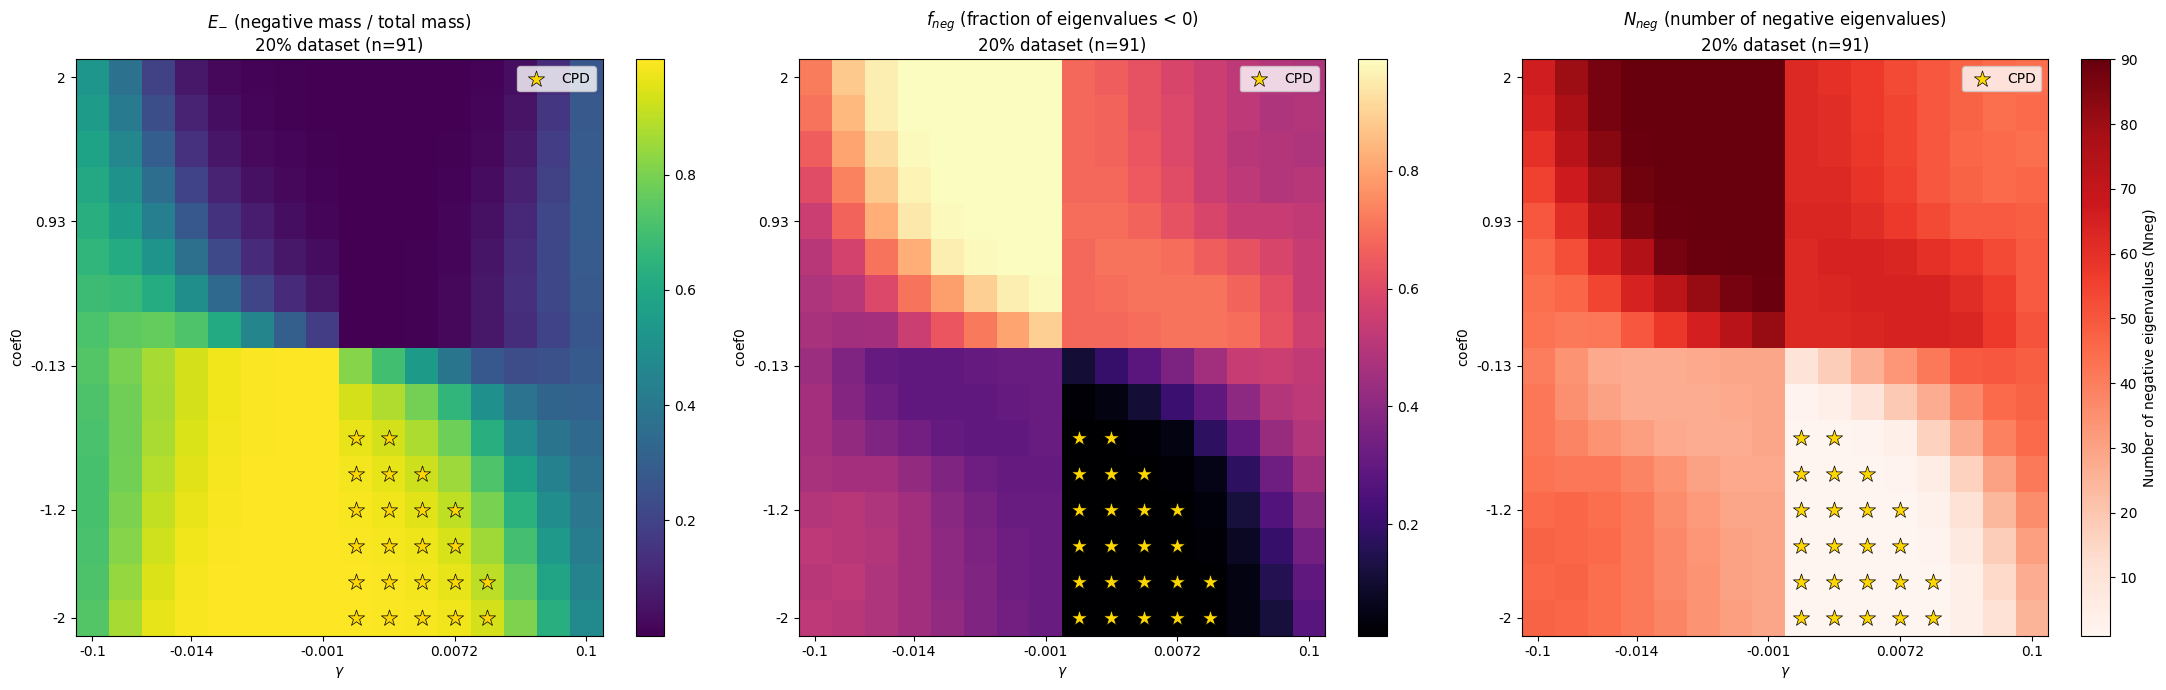

Heatmaps for 20% saved to: img/heatmaps_exp3_20pct.png

Generating heatmaps for 40% dataset


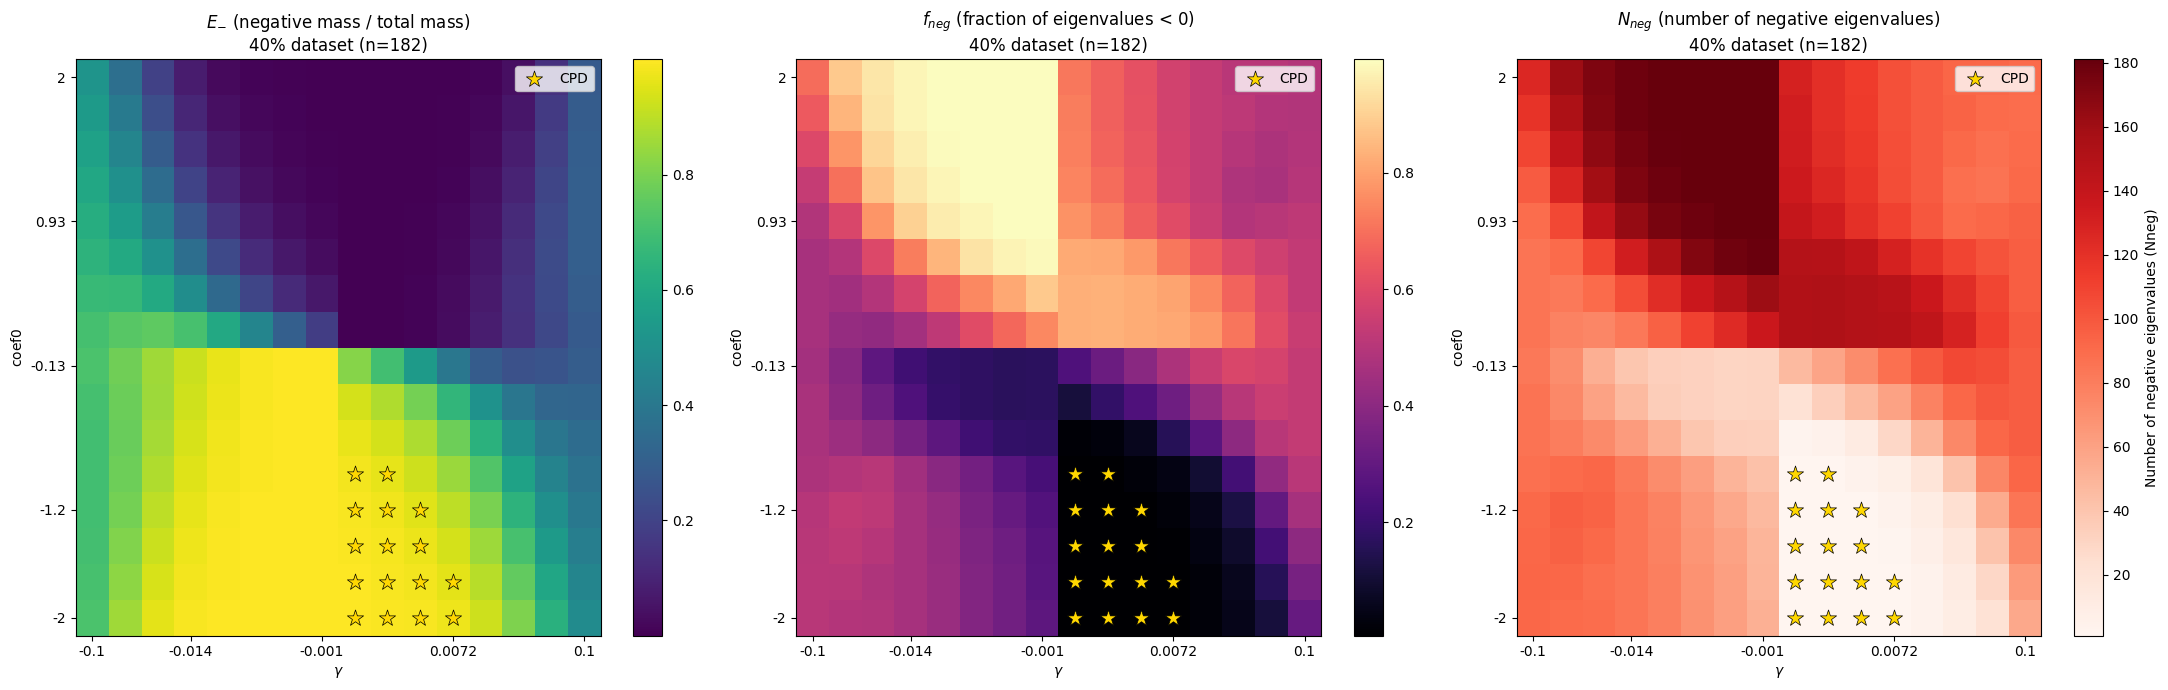

Heatmaps for 40% saved to: img/heatmaps_exp3_40pct.png

Generating heatmaps for 60% dataset


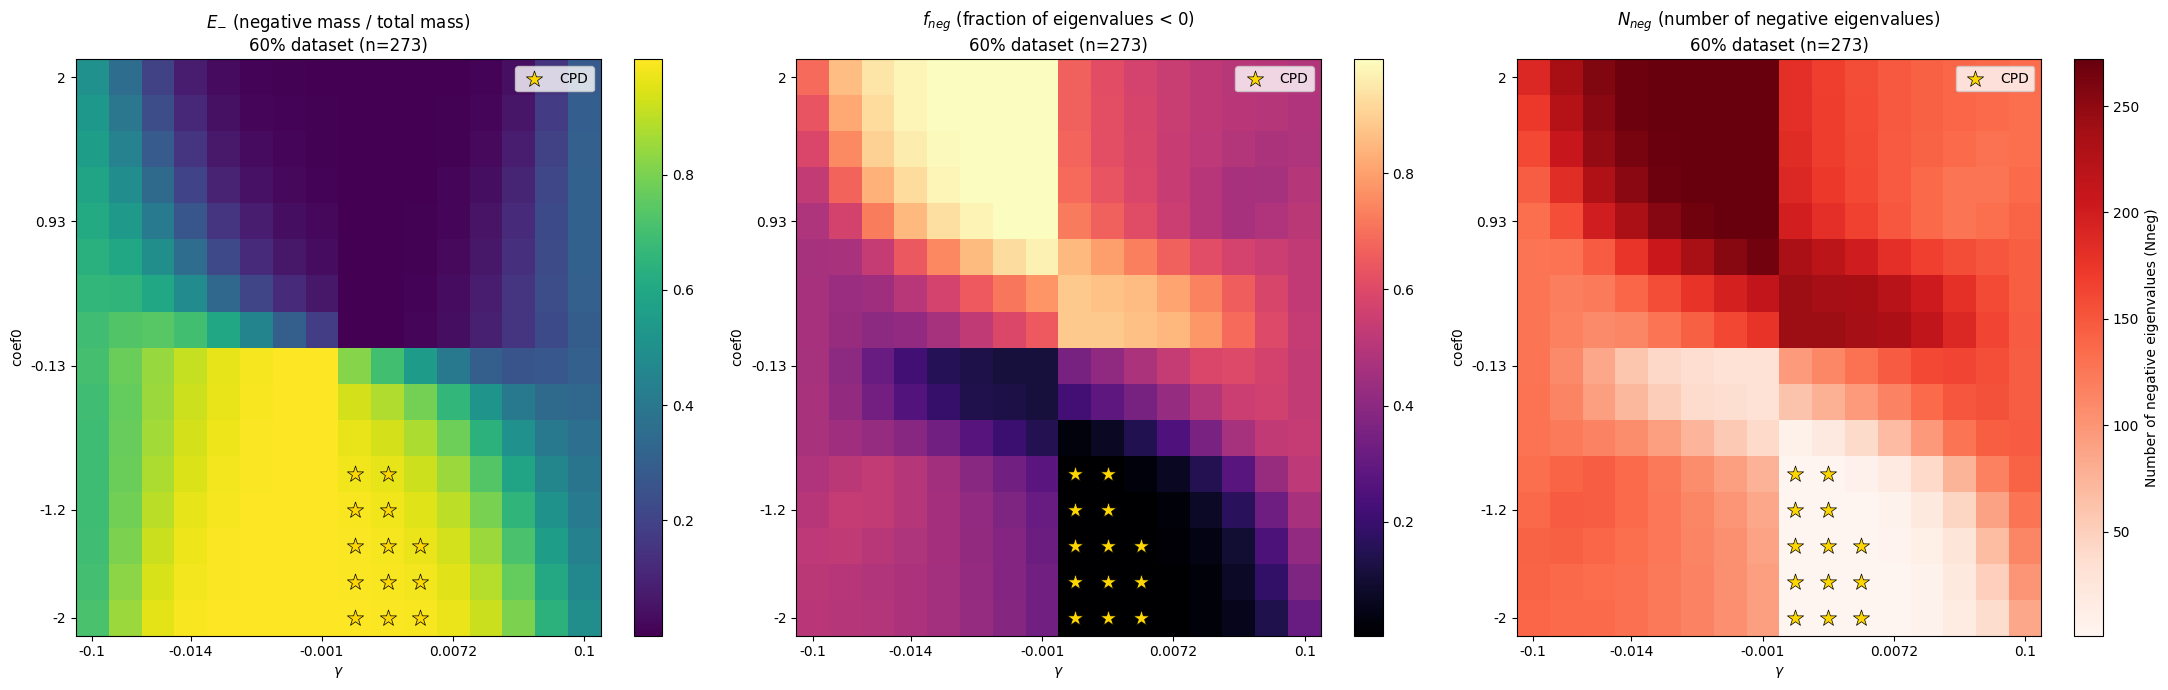

Heatmaps for 60% saved to: img/heatmaps_exp3_60pct.png

Generating heatmaps for 80% dataset


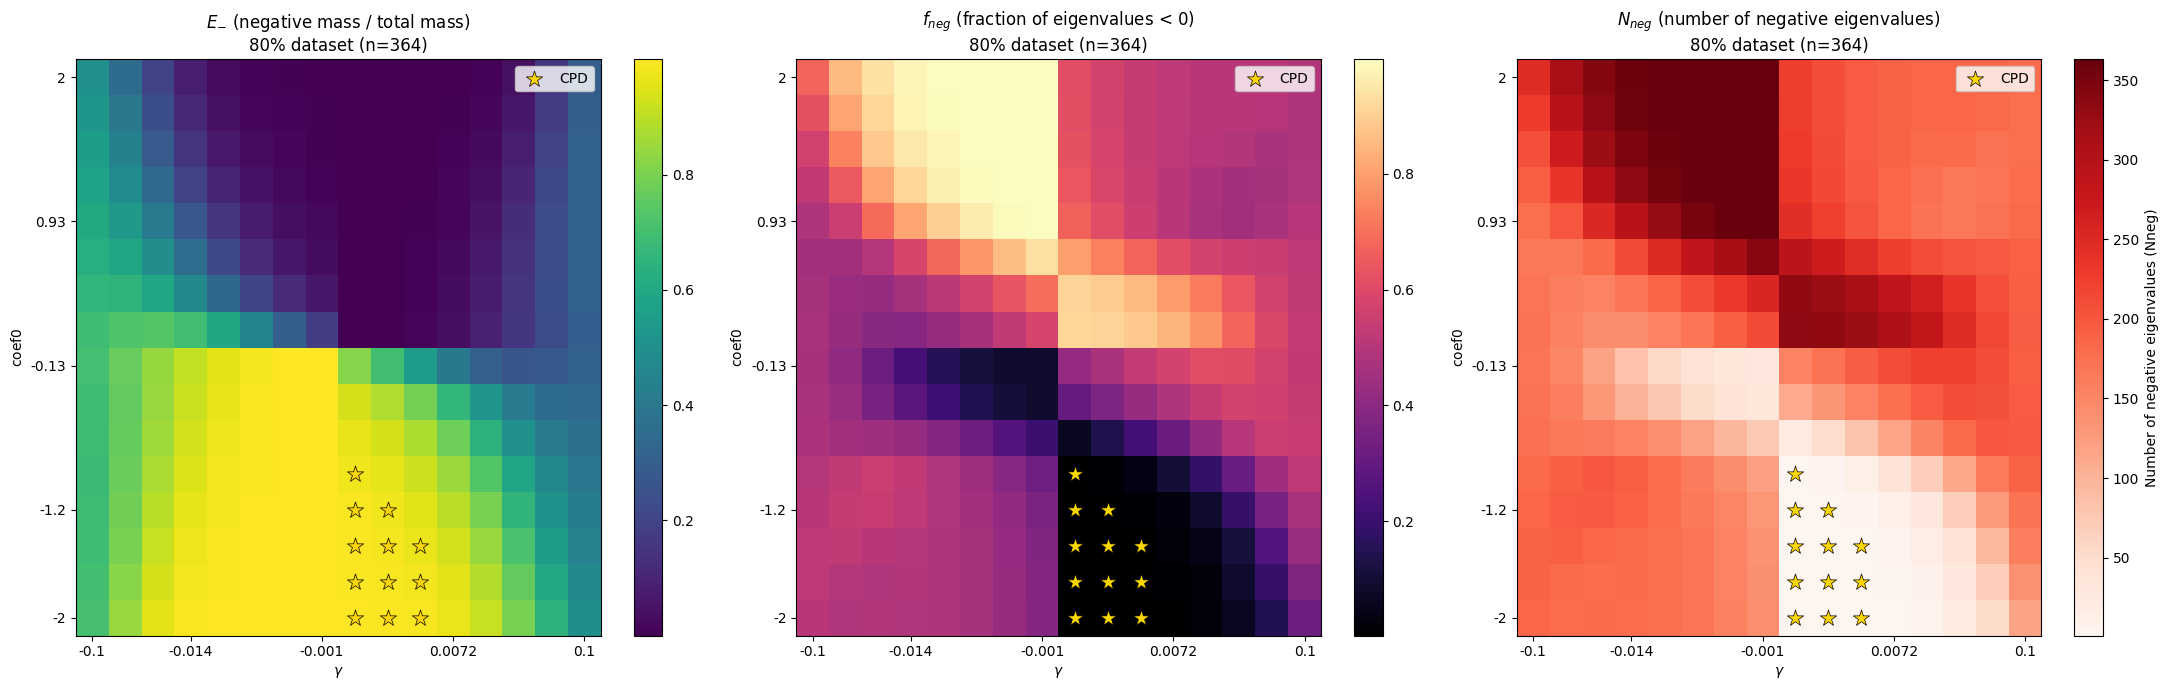

Heatmaps for 80% saved to: img/heatmaps_exp3_80pct.png

All heatmaps created!


In [ ]:
print("="*80)
print("Creating Heatmaps for Each Dataset Size")
print("="*80)

# Create heatmaps for each dataset fraction
for frac, name in zip(dataset_fractions, dataset_names):
    print(f"\n{'='*60}")
    print(f"Generating heatmaps for {name} dataset")
    print(f"{'='*60}")
    
    data = results_by_size[name]
    
    # Reconstruct heatmap matrices from stored results
    n_gammas = len(gammas_exp3)
    n_coef0s = len(coef0s_exp3)
    
    # Initialize matrices
    H1_size = np.zeros((n_coef0s, n_gammas))  # Negative mass fraction
    H2_size = np.zeros((n_coef0s, n_gammas))  # Fraction of negative eigenvalues
    H3_size = np.zeros((n_coef0s, n_gammas))  # Number of negative eigenvalues
    H4_size = np.zeros((n_coef0s, n_gammas), dtype=bool)
    
    # Fill matrices
    for idx, (gamma, c) in enumerate(data['results']['param_combinations']):
        i = np.where(np.isclose(gammas_exp3, gamma))[0][0]
        j = np.where(np.isclose(coef0s_exp3, c))[0][0]
        
        H1_size[j, i] = data['negative_mass_fraction'][idx]
        H2_size[j, i] = data['n_negative_eigenvalues'][idx] / data['n_train']
        H3_size[j, i] = data['n_negative_eigenvalues'][idx]
        H4_size[j, i] = data['is_cpd'][idx]
    
    # Create figure for this dataset size
    fig, axes = plt.subplots(1, 3, figsize=(22, 7))
    
    # Select indices for tick labeling
    x_idx = np.linspace(0, len(gammas_exp3) - 1, min(len(gammas_exp3), 5), dtype=int)
    y_idx = np.linspace(0, len(coef0s_exp3) - 1, min(len(coef0s_exp3), 5), dtype=int)
    
    # Heatmap 1: Negative mass fraction
    im1 = axes[0].imshow(H1_size, origin="lower", aspect="auto", cmap="viridis")
    axes[0].set_title(f"$E_{{-}}$ (negative mass / total mass)\n{name} dataset (n={data['n_train']})")
    axes[0].set_xticks(x_idx)
    axes[0].set_xticklabels([f"{gammas_exp3[i]:.2g}" for i in x_idx])
    axes[0].set_yticks(y_idx)
    axes[0].set_yticklabels([f"{coef0s_exp3[i]:.2g}" for i in y_idx])
    axes[0].set_xlabel(r"$\gamma$")
    axes[0].set_ylabel(r"$\mathrm{coef0}$")
    fig.colorbar(im1, ax=axes[0])
    
    # Heatmap 2: Fraction of negative eigenvalues
    im2 = axes[1].imshow(H2_size, origin="lower", aspect="auto", cmap="magma")
    axes[1].set_title(f"$f_{{neg}}$ (fraction of eigenvalues < 0)\n{name} dataset (n={data['n_train']})")
    axes[1].set_xticks(x_idx)
    axes[1].set_xticklabels([f"{gammas_exp3[i]:.2g}" for i in x_idx])
    axes[1].set_yticks(y_idx)
    axes[1].set_yticklabels([f"{coef0s_exp3[i]:.2g}" for i in y_idx])
    axes[1].set_xlabel(r"$\gamma$")
    axes[1].set_ylabel(r"$\mathrm{coef0}$")
    fig.colorbar(im2, ax=axes[1])
    
    # Heatmap 3: Number of negative eigenvalues
    ax3 = axes[2]
    ax3.set_facecolor("lightgreen")
    Nneg = H3_size.astype(float).copy()
    Nneg[Nneg == 0] = np.nan
    cmap = mpl.colormaps.get_cmap("Reds").copy()
    cmap.set_bad(color="lightblue")
    im3 = ax3.imshow(Nneg, origin="lower", aspect="auto", cmap=cmap)
    ax3.set_title(f"$N_{{neg}}$ (number of negative eigenvalues)\n{name} dataset (n={data['n_train']})")
    ax3.set_xticks(x_idx)
    ax3.set_xticklabels([f"{gammas_exp3[i]:.2g}" for i in x_idx])
    ax3.set_yticks(y_idx)
    ax3.set_yticklabels([f"{coef0s_exp3[i]:.2g}" for i in y_idx])
    ax3.set_xlabel(r"$\gamma$")
    ax3.set_ylabel(r"$\mathrm{coef0}$")
    cbar = fig.colorbar(im3, ax=ax3)
    cbar.set_label("Number of negative eigenvalues (Nneg)")
    
    # Mark CPD kernels with stars on all heatmaps
    cpd_indices = np.argwhere(H4_size)
    for ax in axes:
        if len(cpd_indices) > 0:
            ax.scatter(cpd_indices[:, 1], cpd_indices[:, 0], 
                      marker='*', s=150, c='gold', edgecolors='black', 
                      linewidth=0.5, label='CPD', zorder=5)
            ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig(f'img/heatmaps_exp3_{name.replace("%", "pct")}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Heatmaps for {name} saved to: img/heatmaps_exp3_{name.replace('%', 'pct')}.png")

print("\n" + "="*80)
print("All heatmaps created!")
print("="*80)

Difference Heatmaps: 80% vs 20% Dataset


<>:84: SyntaxWarning: invalid escape sequence '\g'
<>:84: SyntaxWarning: invalid escape sequence '\g'
/var/folders/k9/mks7h9qd0d78rb_jq6d_xkw80000gn/T/ipykernel_39951/3172039907.py:84: SyntaxWarning: invalid escape sequence '\g'
  """vmax3 = max(abs(diff_H3.min()), abs(diff_H3.max()))


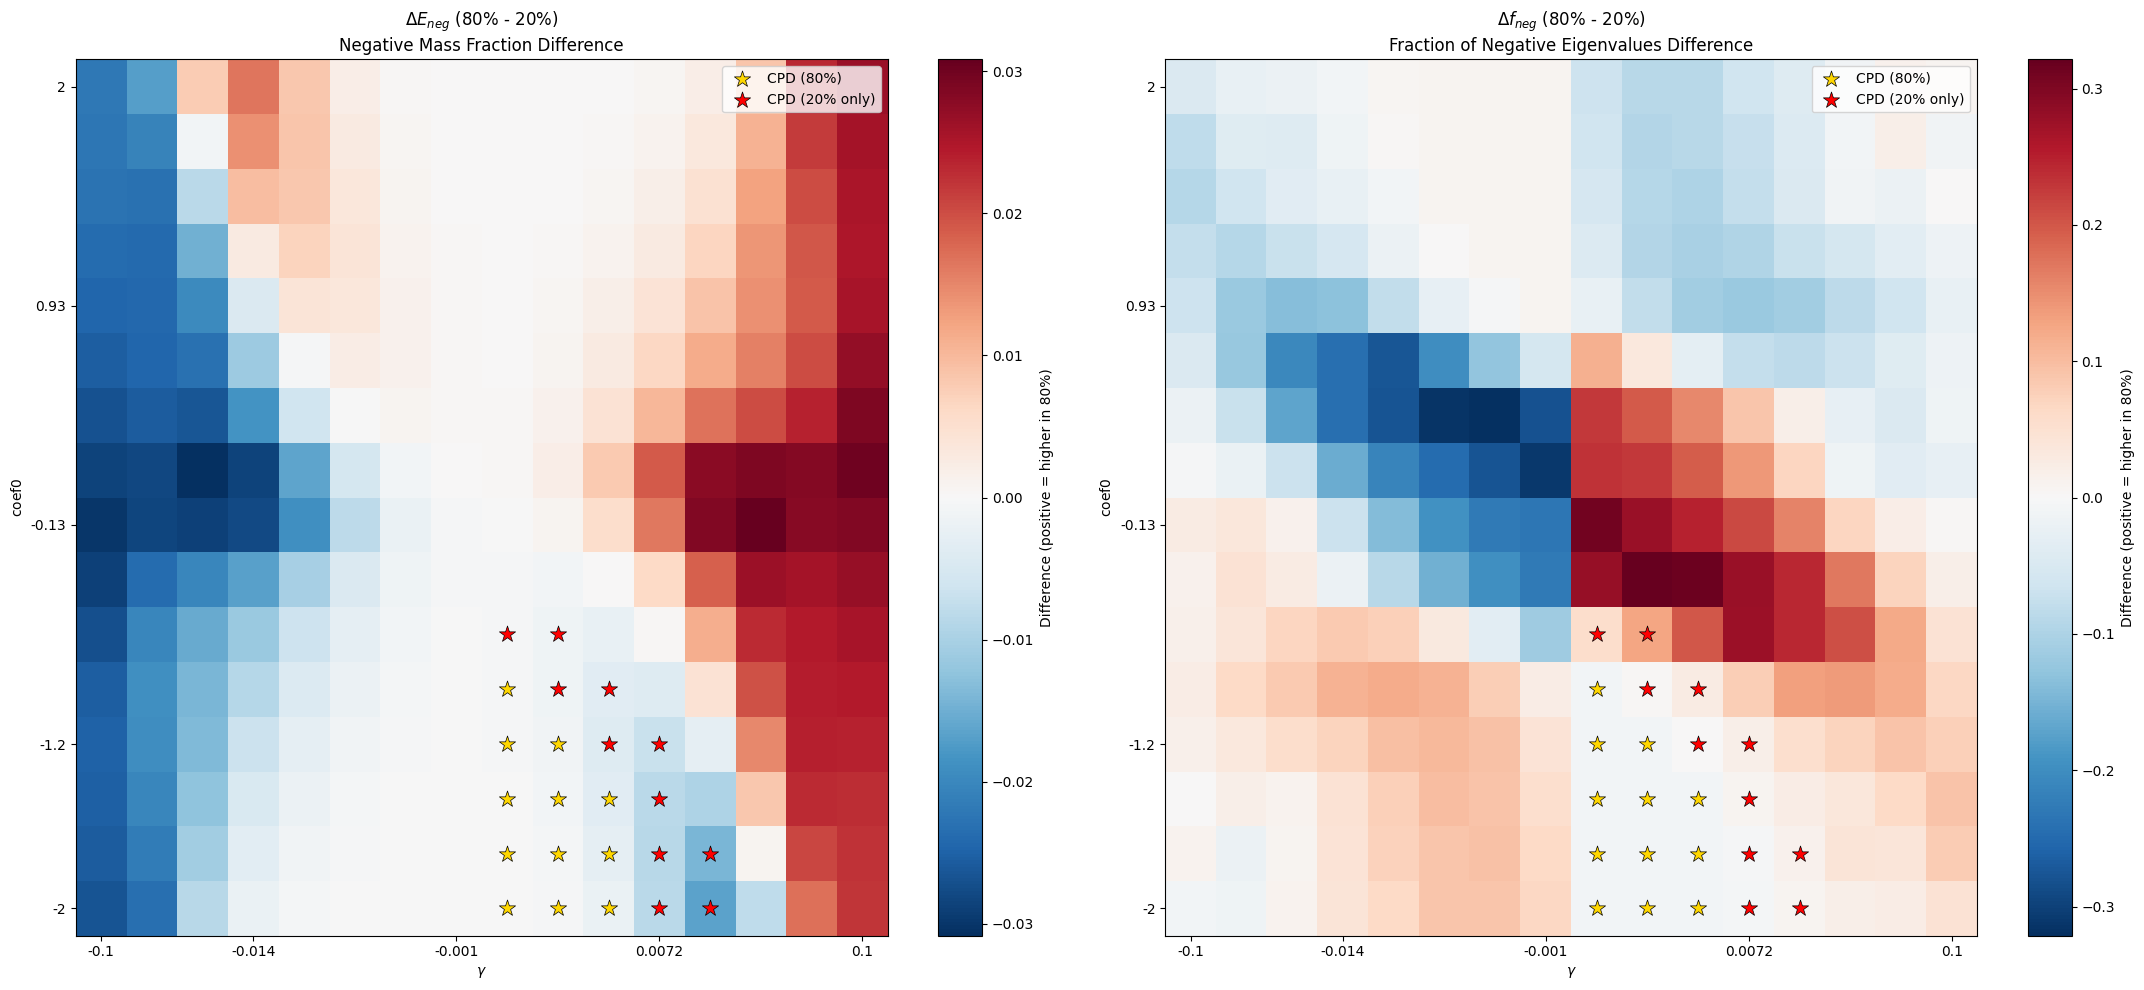


Difference Statistics:
Negative Mass Fraction (E_neg):
  Mean difference: -0.000000
  Max increase (80% higher): 0.030825
  Max decrease (20% higher): -0.030825
  Std of differences: 0.014931

Fraction of Negative Eigenvalues (f_neg):
  Mean difference: -0.000000
  Max increase (80% higher): 0.321429
  Max decrease (20% higher): -0.321429
  Std of differences: 0.113246

Number of Negative Eigenvalues (N_neg):
  Mean difference: 136.50
  Max increase (80% higher): 273.00
  Max decrease (20% higher): 0.00
  Std of differences: 72.72

Plot saved to: img/heatmaps_diff_80pct_vs_20pct.png


In [ ]:
print("="*80)
print("Difference Heatmaps: 80% vs 20% Dataset")
print("="*80)

# Extract data for both datasets
data_20 = results_by_size['20%']
data_80 = results_by_size['80%']

# Reconstruct heatmap matrices for both datasets
n_gammas = len(gammas_exp3)
n_coef0s = len(coef0s_exp3)

# Initialize matrices for 20%
H1_20 = np.zeros((n_coef0s, n_gammas))          # Negative mass fraction
H2_20 = np.zeros((n_coef0s, n_gammas))          # Fraction of negative eigenvalues
H3_20 = np.zeros((n_coef0s, n_gammas))          # Number of negative eigenvalues
H4_20 = np.zeros((n_coef0s, n_gammas), dtype=bool)

# Fill matrices for 20%
for idx, (gamma, c) in enumerate(data_20['results']['param_combinations']):
    i = np.where(np.isclose(gammas_exp3, gamma))[0][0]
    j = np.where(np.isclose(coef0s_exp3, c))[0][0]

    H1_20[j, i] = data_20['negative_mass_fraction'][idx]
    H2_20[j, i] = data_20['n_negative_eigenvalues'][idx] / data_20['n_train']
    H3_20[j, i] = data_20['n_negative_eigenvalues'][idx]
    H4_20[j, i] = data_20['is_cpd'][idx]

# Initialize matrices for 80%
H1_80 = np.zeros((n_coef0s, n_gammas))
H2_80 = np.zeros((n_coef0s, n_gammas))
H3_80 = np.zeros((n_coef0s, n_gammas))
H4_80 = np.zeros((n_coef0s, n_gammas), dtype=bool)

# Fill matrices for 80%
for idx, (gamma, c) in enumerate(data_80['results']['param_combinations']):
    i = np.where(np.isclose(gammas_exp3, gamma))[0][0]
    j = np.where(np.isclose(coef0s_exp3, c))[0][0]

    H1_80[j, i] = data_80['negative_mass_fraction'][idx]
    H2_80[j, i] = data_80['n_negative_eigenvalues'][idx] / data_80['n_train']
    H3_80[j, i] = data_80['n_negative_eigenvalues'][idx]
    H4_80[j, i] = data_80['is_cpd'][idx]

# Compute differences (80% - 20%)
diff_H1 = H1_80 - H1_20  # Difference in negative mass fraction
diff_H2 = H2_80 - H2_20  # Difference in fraction of negative eigenvalues
diff_H3 = H3_80 - H3_20  # Difference in number of negative eigenvalues

# Create figure with difference heatmaps
fig, axes = plt.subplots(1, 2, figsize=(22, 10))

# Select indices for tick labeling
x_idx = np.linspace(0, len(gammas_exp3) - 1, min(len(gammas_exp3), 5), dtype=int)
y_idx = np.linspace(0, len(coef0s_exp3) - 1, min(len(coef0s_exp3), 5), dtype=int)

# Difference Heatmap 1: Negative mass fraction
vmax1 = max(abs(diff_H1.min()), abs(diff_H1.max()))
im1 = axes[0].imshow(diff_H1, origin="lower", aspect="auto", cmap="RdBu_r", vmin=-vmax1, vmax=vmax1)
axes[0].set_title(r"Δ$E_{neg}$ (80% - 20%)" + "\nNegative Mass Fraction Difference")
axes[0].set_xticks(x_idx)
axes[0].set_xticklabels([f"{gammas_exp3[i]:.2g}" for i in x_idx])
axes[0].set_yticks(y_idx)
axes[0].set_yticklabels([f"{coef0s_exp3[i]:.2g}" for i in y_idx])
axes[0].set_xlabel(r"$\gamma$")
axes[0].set_ylabel(r"$\mathrm{coef0}$")
cbar1 = fig.colorbar(im1, ax=axes[0])
cbar1.set_label("Difference (positive = higher in 80%)")

# Difference Heatmap 2: Fraction of negative eigenvalues
vmax2 = max(abs(diff_H2.min()), abs(diff_H2.max()))
im2 = axes[1].imshow(diff_H2, origin="lower", aspect="auto", cmap="RdBu_r", vmin=-vmax2, vmax=vmax2)
axes[1].set_title(r"Δ$f_{neg}$ (80% - 20%)" + "\nFraction of Negative Eigenvalues Difference")
axes[1].set_xticks(x_idx)
axes[1].set_xticklabels([f"{gammas_exp3[i]:.2g}" for i in x_idx])
axes[1].set_yticks(y_idx)
axes[1].set_yticklabels([f"{coef0s_exp3[i]:.2g}" for i in y_idx])
axes[1].set_xlabel(r"$\gamma$")
axes[1].set_ylabel(r"$\mathrm{coef0}$")
cbar2 = fig.colorbar(im2, ax=axes[1])
cbar2.set_label("Difference (positive = higher in 80%)")

# Mark CPD kernels with stars on all difference heatmaps
cpd_indices_80 = np.argwhere(H4_80)
cpd_only_20 = np.argwhere(H4_20 & ~H4_80)  # CPD in 20% but NOT in 80%

for ax in axes:
    # Gold stars for CPD in 80%
    if len(cpd_indices_80) > 0:
        ax.scatter(
            cpd_indices_80[:, 1], cpd_indices_80[:, 0],
            marker='*', s=150, c='gold', edgecolors='black',
            linewidth=0.5, label='CPD (80%)', zorder=5
        )

    # Red stars for CPD in 20% but not in 80%
    if len(cpd_only_20) > 0:
        ax.scatter(
            cpd_only_20[:, 1], cpd_only_20[:, 0],
            marker='*', s=150, c='red', edgecolors='black',
            linewidth=0.5, label='CPD (20% only)', zorder=5
        )

    if len(cpd_indices_80) > 0 or len(cpd_only_20) > 0:
        ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('img/heatmaps_diff_80pct_vs_20pct.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nDifference Statistics:")
print("Negative Mass Fraction (E_neg):")
print(f"  Mean difference: {diff_H1.mean():.6f}")
print(f"  Max increase (80% higher): {diff_H1.max():.6f}")
print(f"  Max decrease (20% higher): {diff_H1.min():.6f}")
print(f"  Std of differences: {diff_H1.std():.6f}")

print("\nFraction of Negative Eigenvalues (f_neg):")
print(f"  Mean difference: {diff_H2.mean():.6f}")
print(f"  Max increase (80% higher): {diff_H2.max():.6f}")
print(f"  Max decrease (20% higher): {diff_H2.min():.6f}")
print(f"  Std of differences: {diff_H2.std():.6f}")

print("\nNumber of Negative Eigenvalues (N_neg):")
print(f"  Mean difference: {diff_H3.mean():.2f}")
print(f"  Max increase (80% higher): {diff_H3.max():.2f}")
print(f"  Max decrease (20% higher): {diff_H3.min():.2f}")
print(f"  Std of differences: {diff_H3.std():.2f}")

print("="*80)
print(f"\nPlot saved to: img/heatmaps_diff_80pct_vs_20pct.png")
print("="*80)


In [22]:
print("="*80)
print("Comparative Analysis Across Dataset Sizes")
print("="*80)

# Create comprehensive comparison table
print("\n" + "-"*80)
print("Performance Summary by Dataset Size")
print("-"*80)
print(f"{'Dataset Size':<15} {'n_train':<10} {'Best F1':<10} {'Mean F1':<10} {'CPD %':<10}")
print("-"*80)

for name in dataset_names:
    data = results_by_size[name]
    best_f1 = data['results']['original']['f1'].max()
    mean_f1 = data['results']['original']['f1'].mean()
    cpd_pct = 100 * np.sum(data['is_cpd']) / len(data['is_cpd'])
    
    print(f"{name:<15} {data['n_train']:<10} {best_f1:<10.4f} {mean_f1:<10.4f} {cpd_pct:<10.1f}")

print("\n" + "-"*80)
print("Correction Method Effectiveness (Mean ΔF1 %)")
print("-"*80)
print(f"{'Dataset Size':<15} {'Shift':<12} {'Clip':<12} {'Clipnorm':<12}")
print("-"*80)

for name in dataset_names:
    data = results_by_size[name]
    shift_mean = data['delta_shift'].mean()
    clip_mean = data['delta_clip'].mean()
    clipnorm_mean = data['delta_clipnorm'].mean()
    
    print(f"{name:<15} {shift_mean:<+12.2f} {clip_mean:<+12.2f} {clipnorm_mean:<+12.2f}")

print("\n" + "-"*80)
print("Kernel Quality Metrics")
print("-"*80)
print(f"{'Dataset Size':<15} {'Mean Neg. Eig.':<18} {'Mean Neg. Mass':<18}")
print("-"*80)

for name in dataset_names:
    data = results_by_size[name]
    mean_neg_eig = data['n_negative_eigenvalues'].mean()
    mean_neg_mass = data['negative_mass_fraction'].mean()
    
    print(f"{name:<15} {mean_neg_eig:<18.2f} {mean_neg_mass:<18.4f}")

print("\n" + "-"*80)
print("Key Observations")
print("-"*80)

# Find which size has best performance
best_sizes = {}
for metric in ['best_f1', 'mean_f1', 'cpd_pct']:
    if metric == 'best_f1':
        values = {name: results_by_size[name]['results']['original']['f1'].max() for name in dataset_names}
    elif metric == 'mean_f1':
        values = {name: results_by_size[name]['results']['original']['f1'].mean() for name in dataset_names}
    else:
        values = {name: 100 * np.sum(results_by_size[name]['is_cpd']) / len(results_by_size[name]['is_cpd']) for name in dataset_names}
    
    best_sizes[metric] = max(values, key=values.get)

print(f"\n✓ Best F1 score achieved with: {best_sizes['best_f1']} dataset")
print(f"✓ Highest mean F1 with: {best_sizes['mean_f1']} dataset")
print(f"✓ Most CPD kernels with: {best_sizes['cpd_pct']} dataset")

# Check if corrections improve more with smaller/larger datasets
print("\n✓ Correction method trends:")
for method_name, method_key in [('Shift', 'delta_shift'), ('Clip', 'delta_clip'), ('Clipnorm', 'delta_clipnorm')]:
    improvements = [results_by_size[name][method_key].mean() for name in dataset_names]
    if improvements[0] > improvements[-1]:
        trend = "more effective with smaller datasets"
    elif improvements[0] < improvements[-1]:
        trend = "more effective with larger datasets"
    else:
        trend = "consistent across dataset sizes"
    print(f"  - {method_name}: {trend}")

print("\n" + "="*80)

Comparative Analysis Across Dataset Sizes

--------------------------------------------------------------------------------
Performance Summary by Dataset Size
--------------------------------------------------------------------------------
Dataset Size    n_train    Best F1    Mean F1    CPD %     
--------------------------------------------------------------------------------
20%             91         0.9863     0.8698     9.0       
40%             182        0.9931     0.8685     6.2       
60%             273        0.9931     0.8724     5.1       
80%             364        0.9931     0.8719     4.7       

--------------------------------------------------------------------------------
Correction Method Effectiveness (Mean ΔF1 %)
--------------------------------------------------------------------------------
Dataset Size    Shift        Clip         Clipnorm    
--------------------------------------------------------------------------------
20%             -162.92      +5.07

Visualizing Dataset Size Impact - CPD Kernel Percentage


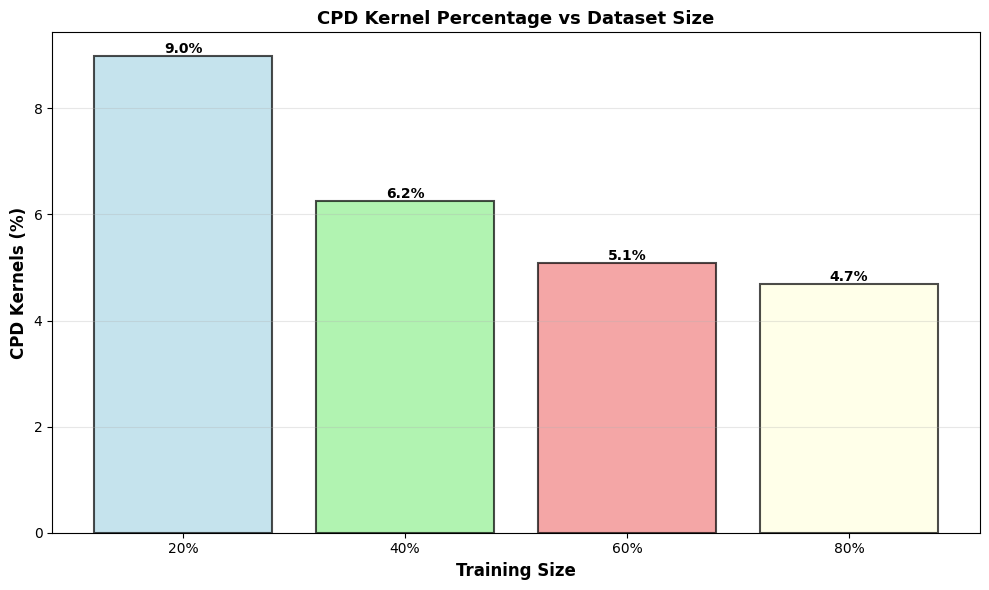


Visualization saved to: img/cpd_percentage_vs_dataset_size.png


In [23]:
print("="*80)
print("Visualizing Dataset Size Impact - CPD Kernel Percentage")
print("="*80)

# Create single plot for CPD Kernel Percentage
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

cpd_percentages = [100 * np.sum(results_by_size[name]['is_cpd']) / len(results_by_size[name]['is_cpd']) 
                   for name in dataset_names]
bars = ax.bar(dataset_names, cpd_percentages, color=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow'], 
              alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Training Size', fontsize=12, fontweight='bold')
ax.set_ylabel('CPD Kernels (%)', fontsize=12, fontweight='bold')
ax.set_title('CPD Kernel Percentage vs Dataset Size', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, cpd_percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('img/cpd_percentage_vs_dataset_size.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: img/cpd_percentage_vs_dataset_size.png")
print("="*80)


Baseline F1 vs ΔF1 Plot for 20% Dataset

Generating correction_plots_baseline for 20% dataset (n_train=91)


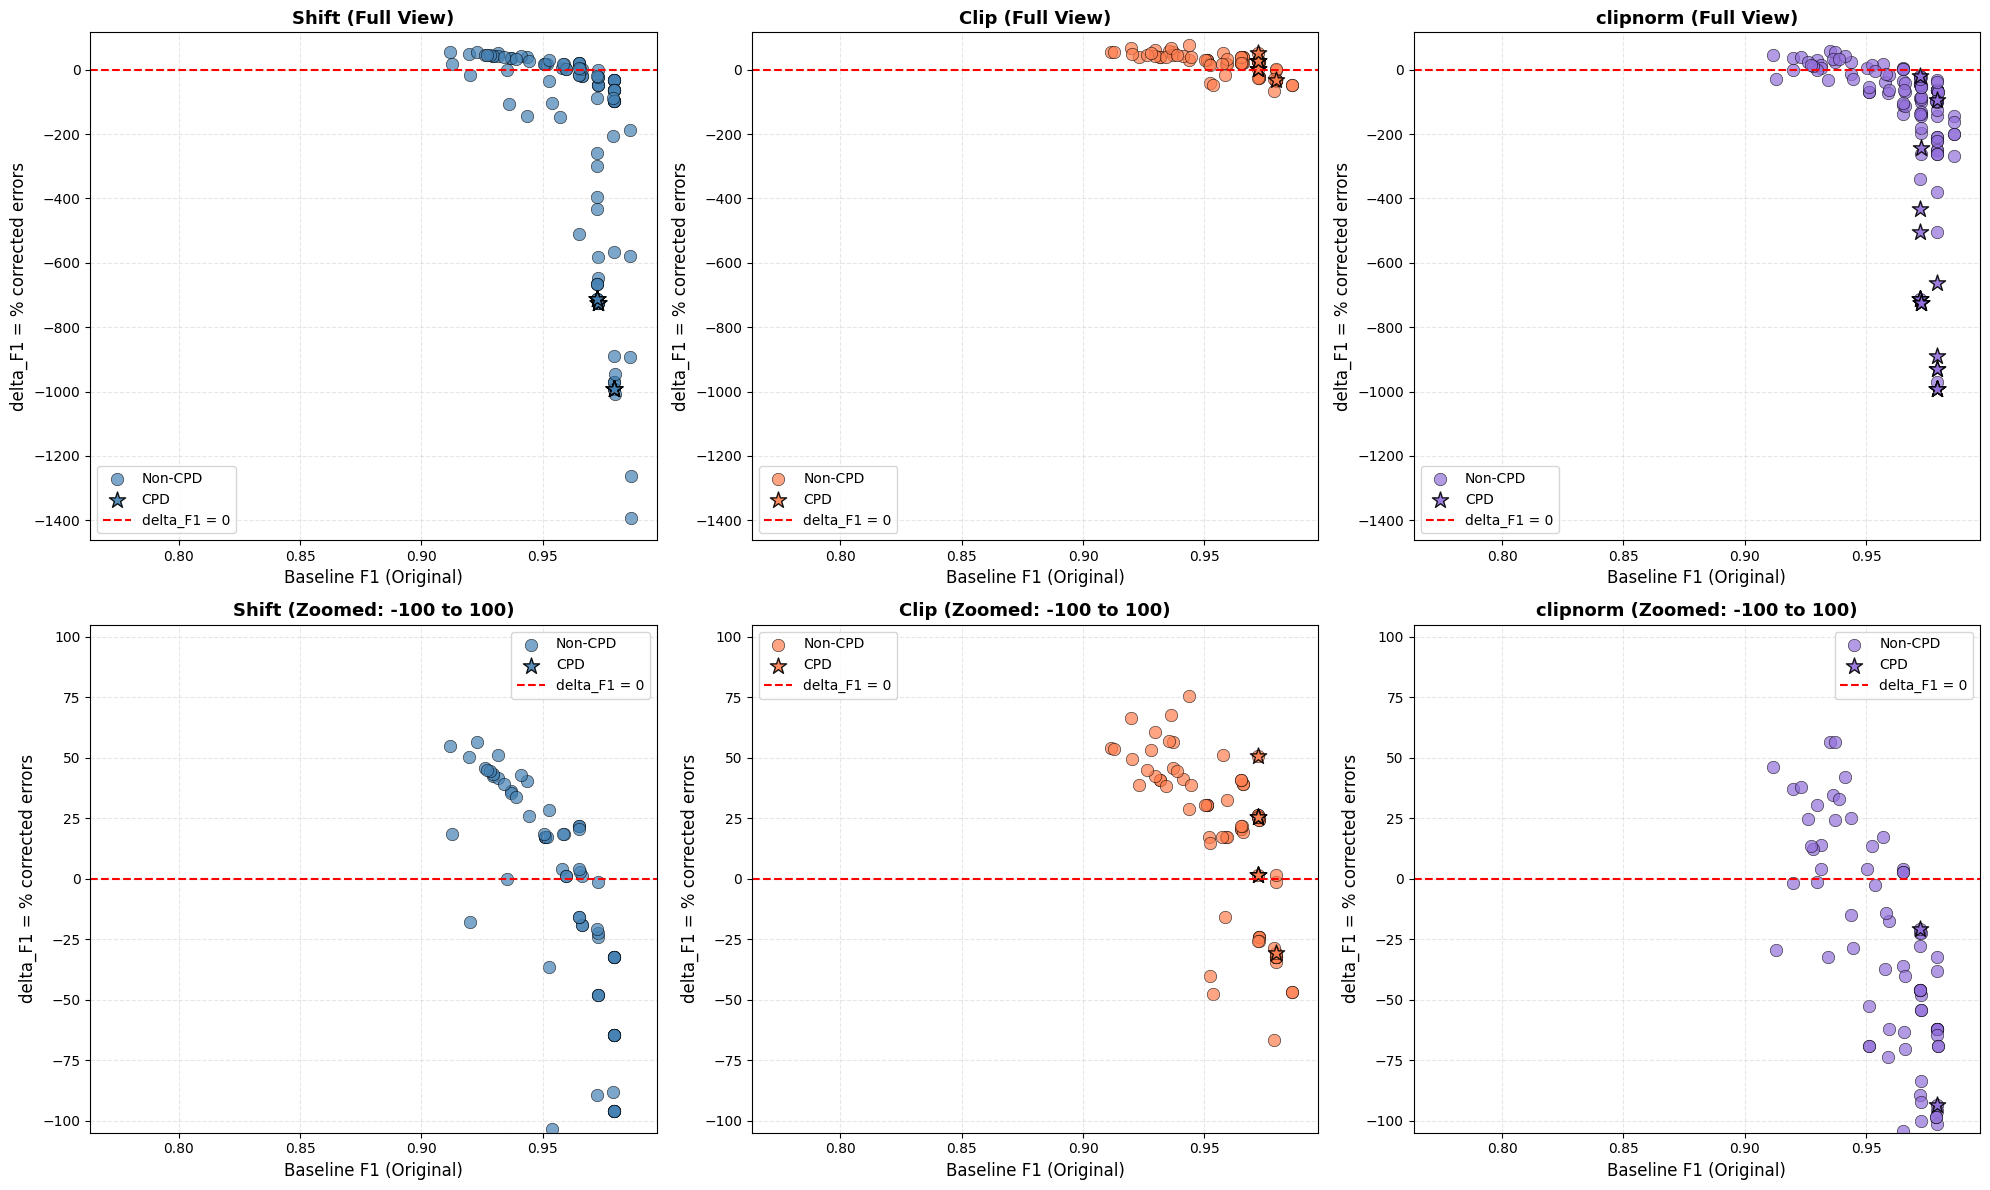

Plot saved to: img/baseline_vs_delta_3methods_20pct.png


In [24]:
print("="*80)
print("Baseline F1 vs ΔF1 Plot for 20% Dataset")
print("="*80)

# Extract data for 20% dataset
data_20 = results_by_size['20%']

print(f"\nGenerating correction_plots_baseline for 20% dataset (n_train={data_20['n_train']})")

correction_plots_baseline(
    data_20['results'], 
    data_20['delta_shift'], 
    data_20['delta_clip'], 
    data_20['delta_clipnorm'], 
    data_20['is_cpd'],
    suffix='_20pct'
)

print(f"Plot saved to: img/baseline_vs_delta_3methods_20pct.png")
print("="*80)